# Homework Assignment 3: Unsupervised learning and intro to NN

#### Team : Aoi Minamoto, Avinash Pawar, Harshwardhan Patil

# Question 1:

In [1]:
%%capture

# Before starting of the program below code ensures that you have all the necessary libraries installed 
# if not, it installs them.

!pip install numpy
!pip install pandas
!pip install seaborn
!pip install scikit-learn
!pip install opendatasets
!pip install kaggle
!pip install tensorflow

In [2]:
# Importing all the required libraries
import sys
import time
import math
import numpy as np
import pandas as pd
from pathlib import Path
import sklearn
import pickle
import seaborn as sns
import matplotlib as mpl
from pathlib import Path
import opendatasets as od
import tensorflow as tf

In [3]:
# Declaring image properties
import matplotlib.pyplot as plt

plt.rc('font', size=12)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [4]:
# importing warnings package and filtering the warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# setting random seed for entire program
np.random.seed(22)

In [6]:
# here you will declare the names of training and testing data
# if not present provide a kaggle url for downloading the URL 
# and also providing the necessary directory to put these files in.

data_file_names = ["fashion-mnist_train.csv", "fashion-mnist_test.csv"]
kaggle_data_url = "https://www.kaggle.com/datasets/zalando-research/fashionmnist"

datapath = Path() / "fashionmnist"
datapath.mkdir(parents=True, exist_ok=True)

In [7]:
file_present = True
for filename in data_file_names:
    if not (datapath / filename).is_file():
        file_present = False

# below code requires Kaggle Credentials, so follow the following steps to get them
# opendatasets uses the Kaggle Official API for donwloading dataset from Kaggle. 
# Follow these steps to find your API credentials:
# Step 1: Go to https://kaggle.com/me/account (sign in if required).
# Step 2: Scroll down to the "API" section and click "Create New API Token". 
#         This will download a file kaggle.json with the following contents:
# {"username":"YOUR_KAGGLE_USERNAME","key":"YOUR_KAGGLE_KEY"}
# Step 3: When you run opendatsets.download, you will be asked to enter your username & Kaggle API, 
# which you can get from the file downloaded in step 2.
if not file_present:
    od.download(kaggle_data_url)

In [8]:
# Reading the data
data = pd.read_csv(datapath/'fashion-mnist_train.csv')
test_data = pd.read_csv(datapath/'fashion-mnist_test.csv')

In [9]:
# Extracting lables from the data and dropping label column from the data
# for better testing -> data = data.iloc[0:12000, ]
labels = data['label']
test_labels = test_data['label']

In [10]:
data_labels = labels

In [11]:
# Dropping label column from the datasets
data.drop(columns=['label'], axis = 1, inplace = True)
test_data.drop(columns=['label'], axis = 1, inplace = True)

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

In [13]:
# Split the dataset into training and validation data sets
split = StratifiedShuffleSplit(n_splits=1, test_size=1/6, random_state=22)

training_index, val_index = next(split.split(data, labels))

training_data = data.loc[training_index]
training_labels = labels.loc[training_index]

validation_data = data.loc[val_index]
validation_labels = labels.loc[val_index]

In [14]:
training_data.shape, training_labels.shape , validation_data.shape, validation_labels.shape

((50000, 784), (50000,), (10000, 784), (10000,))

In [15]:
test_data.shape, test_labels.shape

((10000, 784), (10000,))

#### Question : Apply PCA to the training portion of the dataset. How many components do you need to preserve 95% of the variance?

In [16]:
from sklearn.decomposition import PCA

In [17]:
pca = PCA(n_components=0.95)
pca.fit(training_data)

PCA(n_components=0.95)

In [18]:
# Transform training and testing data using PCA
pca_training_data = pd.DataFrame(pca.transform(training_data))
pca_validation_data = pd.DataFrame(pca.transform(validation_data))

In [19]:
pca_training_data.shape, training_labels.shape , pca_validation_data.shape, validation_labels.shape

((50000, 187), (50000,), (10000, 187), (10000,))

#### Answer : 
After implementing PCA to the training data, we need to keep 187 components in order to preserve 95% of varience.

#### Question : Train a Random Forest classifier on the reduced dataset. Was training much faster than in Homework 2? Evaluate the classifier on the test set. How does it compare to the classifier from Homework 2?

### Implementing classifier from Homework 2 again

### 1. Random Forest Classifier (without PCA)

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

In [21]:
estimators = np.arange(50, 780, 50)
depths = np.arange(5, 55, 5)
l_e, l_d = estimators.size, depths.size

In [22]:
parameters = {
    "training_accuracy" : np.zeros((l_e, l_d)),
    "validation_accuracy" : np.zeros((l_e, l_d)),
    "training_precision" : np.zeros((l_e, l_d)),
    "validation_precision" : np.zeros((l_e, l_d)),
    "training_recall" : np.zeros((l_e, l_d)),
    "validation_recall" : np.zeros((l_e, l_d)),
    "training_f1_score" : np.zeros((l_e, l_d)),
    "validation_f1_score" : np.zeros((l_e, l_d)),
    "best_accuracy" : -math.inf,
    "best_parameters" : {'n_estimators': -1, 'max_depth': -1},
}

In [23]:
def calculate_metrics(pred_tlabels, training_labels, pred_vlabels,
                      validation_labels, row, column, estimator, depth, parameters):
    # calculating scores on training dataset
    training_precision = precision_score(training_labels, pred_tlabels, average='weighted')
    training_accuracy = accuracy_score(training_labels, pred_tlabels)
    training_recall = recall_score(training_labels, pred_tlabels, average='weighted')
    training_f1_score = f1_score(training_labels, pred_tlabels, average='weighted')

    # calculating scores on validation dataset
    validation_precision = precision_score(validation_labels, pred_vlabels, average='weighted')
    validation_accuracy = accuracy_score(validation_labels, pred_vlabels)
    validation_recall = recall_score(validation_labels, pred_vlabels, average='weighted')
    validation_f1_score = f1_score(validation_labels, pred_vlabels, average='weighted')

    parameters["training_accuracy"][row][column] = training_accuracy
    parameters["validation_accuracy"][row][column] = validation_accuracy
    parameters["training_precision"][row][column] = training_precision
    parameters["validation_precision"][row][column] = validation_precision
    parameters["training_recall"][row][column] = training_recall
    parameters["validation_recall"][row][column] = validation_recall
    parameters["training_f1_score"][row][column] = training_f1_score
    parameters["validation_f1_score"][row][column] = validation_f1_score

    # Keep track of best hyperparameters and corresponding validation accuracy
    if validation_accuracy > parameters["best_accuracy"]:
        parameters["best_accuracy"] = validation_accuracy
        parameters["best_parameters"] = {'n_estimators': estimator, 'max_depth': depth}
    return parameters

In [24]:
def save_dict(file_name, dictonary ):
    with open(file_name, 'wb') as fp:
        pickle.dump(dictonary, fp)

def load_dict(file_name):
    with open(file_name, 'rb') as fp:
        dictonary = pickle.load(fp)
    return dictonary

In [25]:
%%time
file_name = "random_forest_without_pca.pkl"
if Path(file_name).is_file():
    parameters = load_dict(file_name)
else:
    for index_i, estimator in enumerate(estimators):
        for index_j, depth in enumerate(depths):    
            # Declaring a model
            rfc = RandomForestClassifier(n_estimators=estimator, max_depth=depth, n_jobs= -1)

            # Fit model on training data
            rfc.fit(training_data, training_labels)

            # Predicting training labels based on trainig data
            pred_tlabels = rfc.predict(training_data)

            # Predicting validation labels based on validation data
            pred_vlabels = rfc.predict(validation_data)

            parameters = calculate_metrics(pred_tlabels, training_labels, pred_vlabels, 
                                           validation_labels, index_i, index_j, estimator, depth, parameters)
    save_dict(file_name, parameters)

CPU times: total: 16h 34min 21s
Wall time: 1h 7min 48s


In [26]:
print("Best accuracy obtained : ", parameters['best_accuracy'])
print("Optimum value of estimators obtained : ", parameters['best_parameters']['n_estimators'])
print("Optimum value of depth obtained : ", parameters['best_parameters']['max_depth'])

Best accuracy obtained :  0.89
Optimum value of estimators obtained :  550
Optimum value of depth obtained :  45


In [27]:
# Creating model with best hyperparameters for executing it on test data
rfc_model = RandomForestClassifier(n_estimators=parameters['best_parameters']['n_estimators'], max_depth=parameters['best_parameters']['max_depth'], n_jobs= -1)

In [28]:
%%time
# save the model after calling .fit method or retriving already saved model
filename = 'rfc_model.sav'

if Path(filename).is_file():
    rfc_model = pickle.load(open(filename, 'rb'))
else:
    rfc_model.fit(training_data, training_labels)
    pickle.dump(rfc_model, open(filename, 'wb'))

CPU times: total: 10min 29s
Wall time: 41.8 s


In [29]:
# Predicting test data labels based on trained model
test_labels_pred = rfc_model.predict(test_data)

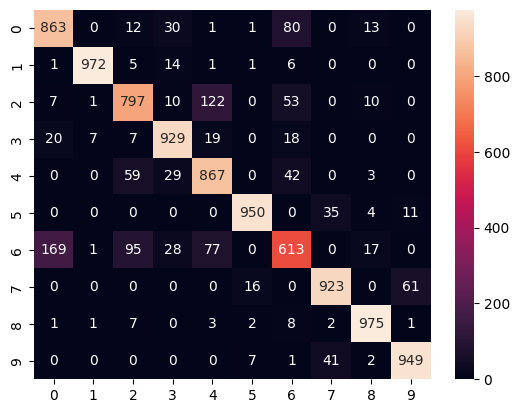

In [30]:
# plotting confusion matrix
plt.rc('font', size=10)  
cm = confusion_matrix(test_labels, test_labels_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [31]:
def print_test_metrics(test_labels, test_labels_pred):
    print(f"Precision Score :  {precision_score(test_labels, test_labels_pred, average='weighted') :.4f} ")
    print(f"Accuracy Score \t:  {accuracy_score(test_labels, test_labels_pred) :.4f} ")
    print(f"Recall Score \t:  {recall_score(test_labels, test_labels_pred, average='weighted') :.4f} ")
    print(f"F1 Score \t:  {f1_score(test_labels, test_labels_pred, average='weighted') :.4f} ")

In [32]:
print_test_metrics(test_labels, test_labels_pred)

Precision Score :  0.8825 
Accuracy Score 	:  0.8838 
Recall Score 	:  0.8838 
F1 Score 	:  0.8822 


### 2. Random Forest Classifier (with PCA)

In [33]:
estimators = np.arange(50, 180, 20)
depths = np.arange(5, 55, 5)
l_e, l_d = estimators.size, depths.size

In [34]:
parameters_pca = {
    "training_accuracy" : np.zeros((l_e, l_d)),
    "validation_accuracy" : np.zeros((l_e, l_d)),
    "training_precision" : np.zeros((l_e, l_d)),
    "validation_precision" : np.zeros((l_e, l_d)),
    "training_recall" : np.zeros((l_e, l_d)),
    "validation_recall" : np.zeros((l_e, l_d)),
    "training_f1_score" : np.zeros((l_e, l_d)),
    "validation_f1_score" : np.zeros((l_e, l_d)),
    "best_accuracy" : -math.inf,
    "best_parameters" : {'n_estimators': -1, 'max_depth': -1}
}

In [35]:
%%time
file_name = "random_forest_with_pca.pkl"
if Path(file_name).is_file():
    parameters_pca = load_dict(file_name)
else:
    for index_i, estimator in enumerate(estimators):
        for index_j, depth in enumerate(depths):    
            # Declaring a model
            rfc = RandomForestClassifier(n_estimators=estimator, max_depth=depth, n_jobs= -1)

            # Fit model on training data
            rfc.fit(pca_training_data, training_labels)

            # Predicting training labels based on trainig data
            pred_tlabels = rfc.predict(pca_training_data)

            # Predicting validation labels based on validation data
            pred_vlabels = rfc.predict(pca_validation_data)

            parameters_pca = calculate_metrics(pred_tlabels, training_labels, pred_vlabels, 
                                           validation_labels, index_i, index_j, estimator, depth, parameters_pca)
    save_dict(file_name, parameters_pca)

CPU times: total: 3h 18min 12s
Wall time: 13min 48s


In [36]:
print("Best accuracy obtained : ", parameters_pca['best_accuracy'])
print("Optimum value of estimators obtained : ", parameters_pca['best_parameters']['n_estimators'])
print("Optimum value of depth obtained : ", parameters_pca['best_parameters']['max_depth'])

Best accuracy obtained :  0.8708
Optimum value of estimators obtained :  170
Optimum value of depth obtained :  35


In [37]:
# Creating model with best hyperparameters for executing it on test data
rfc_model_pca = RandomForestClassifier(n_estimators=parameters_pca['best_parameters']['n_estimators'], max_depth=parameters_pca['best_parameters']['max_depth'], n_jobs= -1)

In [38]:
%%time
# save the model after calling .fit method or retriving already saved model
filename = 'rfc_model_pca.sav'

if Path(filename).is_file():
    rfc_model_pca = pickle.load(open(filename, 'rb'))
else:
    rfc_model_pca.fit(pca_training_data, training_labels)
    pickle.dump(rfc_model_pca, open(filename, 'wb'))

CPU times: total: 5min
Wall time: 19.9 s


In [39]:
# Predicting test data labels based on trained model
pca_test_data = pd.DataFrame(pca.transform(test_data))
test_labels_pred = rfc_model_pca.predict(pca_test_data)

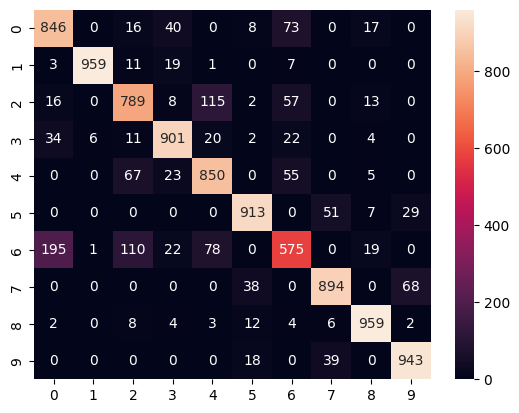

In [40]:
# plotting confusion matrix
plt.rc('font', size=10)  
cm = confusion_matrix(test_labels, test_labels_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [41]:
print_test_metrics(test_labels, test_labels_pred)

Precision Score :  0.8616 
Accuracy Score 	:  0.8629 
Recall Score 	:  0.8629 
F1 Score 	:  0.8610 


It appears that for same number of trees and with same depth, the random forest with PCA takes relatively less time then the random forest without PCA. This is because the dimentionality is reduced and thus the complexity in the data is also reduced.

If we look at the accuracy produced by both models, there is no huge gap in between. So, reducing dimentionality to save time makes sense here.

#### Question: Plot 10 random images in the original form (without PCA) and then plot them after you kept 95% of variance using PCA.

In [42]:
# function to plot digits into an image format
def plot_data(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

##### Random 10 samples from Training data before implementing PCA

In [43]:
random_sample_indexes = training_data.sample(n=10, random_state=12).index

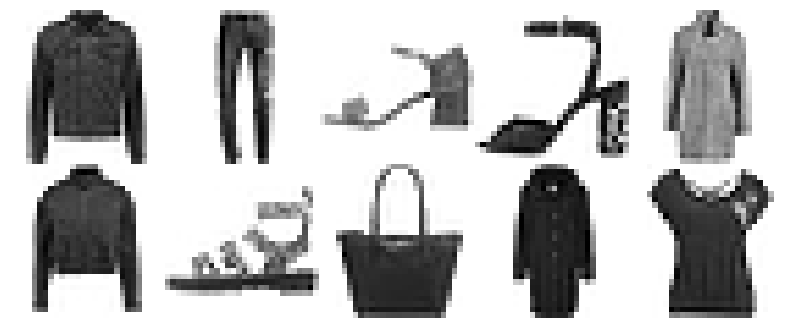

In [44]:
plt.figure(figsize=(10, 4))
for index_i, image_index in enumerate(random_sample_indexes):
    plt.subplot(2, 5, index_i + 1)
    plot_data(training_data.iloc[[image_index]].to_numpy())
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

##### Random 10 samples from Training data After implementing PCA

In [45]:
training_data_recovered = pd.DataFrame(pca.inverse_transform(pca_training_data))

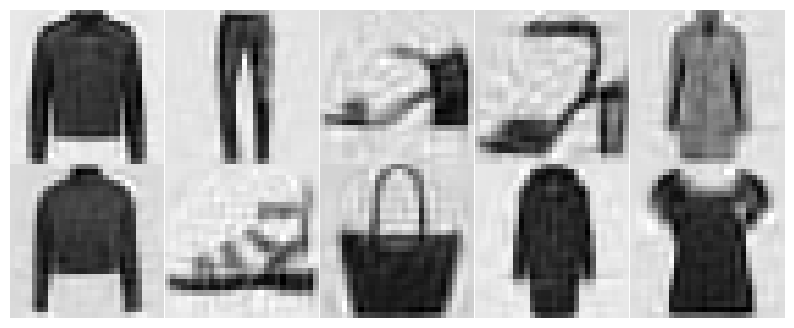

In [46]:
plt.figure(figsize=(10, 4))
for index_i, image_index in enumerate(random_sample_indexes):
    plt.subplot(2, 5, index_i + 1)
    plot_data(training_data_recovered.iloc[[image_index]].to_numpy())
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

#### Question: How much of the variance is explained with the first two principal components? 

In [47]:
print(f"The first component explains {pca.explained_variance_ratio_[0] * 100:.4f} % variance")

The first component explains 29.0214 % variance


In [48]:
print(f"The Second component explains {pca.explained_variance_ratio_[1] * 100:.4f} % variance")

The Second component explains 17.7579 % variance


### Question:
#### Use PCA to reduce dimensionality to only 2 dimensions. Plot 1000 random images from the training set in the 2D space spanned by the first two principal components. Use a scatterplot with 10 different colors to represent each image’s target class. Repeat the process and create the same type of plots for t-SNE, LLE and MDS. [6 points] Which of the visualizations do you prefer and why? [1 point]


In [49]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.04, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = plt.cm.jet
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1],
                    c=[cmap(float(digit) / 9)], alpha=0.5)
    plt.axis("off")
    ax = plt.gca()  # get current axes
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(float(y[index]) / 9),
                         fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"),
                                          image_coord)
                ax.add_artist(imagebox)

In [50]:
# Plot the first two principal components
def plot_principal_components(data, labels, figsize=(13, 10)):
    plt.figure(figsize=figsize)
    for i in range(10):
        plt.scatter(data[labels == i][:, 0], data[labels == i][:, 1], label=str(i), cmap="jet", alpha=0.5)
    plt.axis('off')
    plt.colorbar()
    plt.legend()
    plt.show()

### 1. PCA

In [51]:
X = training_data
y = training_labels

In [52]:
X.shape, y.shape

((50000, 784), (50000,))

In [53]:
pca = PCA(n_components=2, random_state=22)

In [54]:
X_pca_reduced = pca.fit_transform(X)

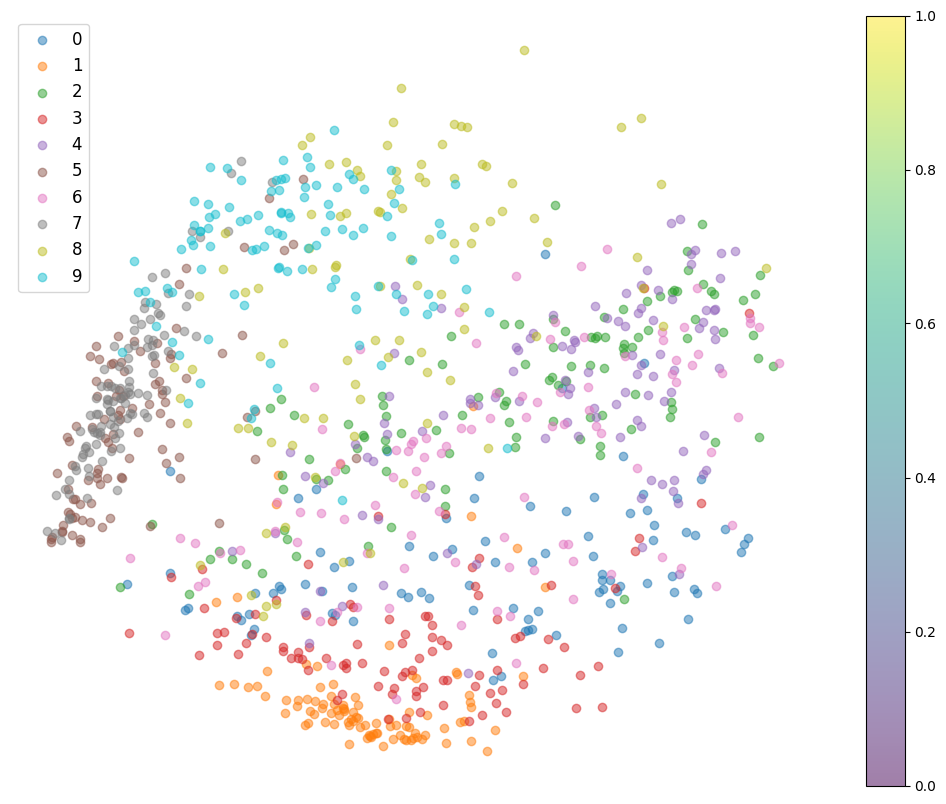

In [55]:
plot_principal_components(X_pca_reduced[:1000], y[:1000])

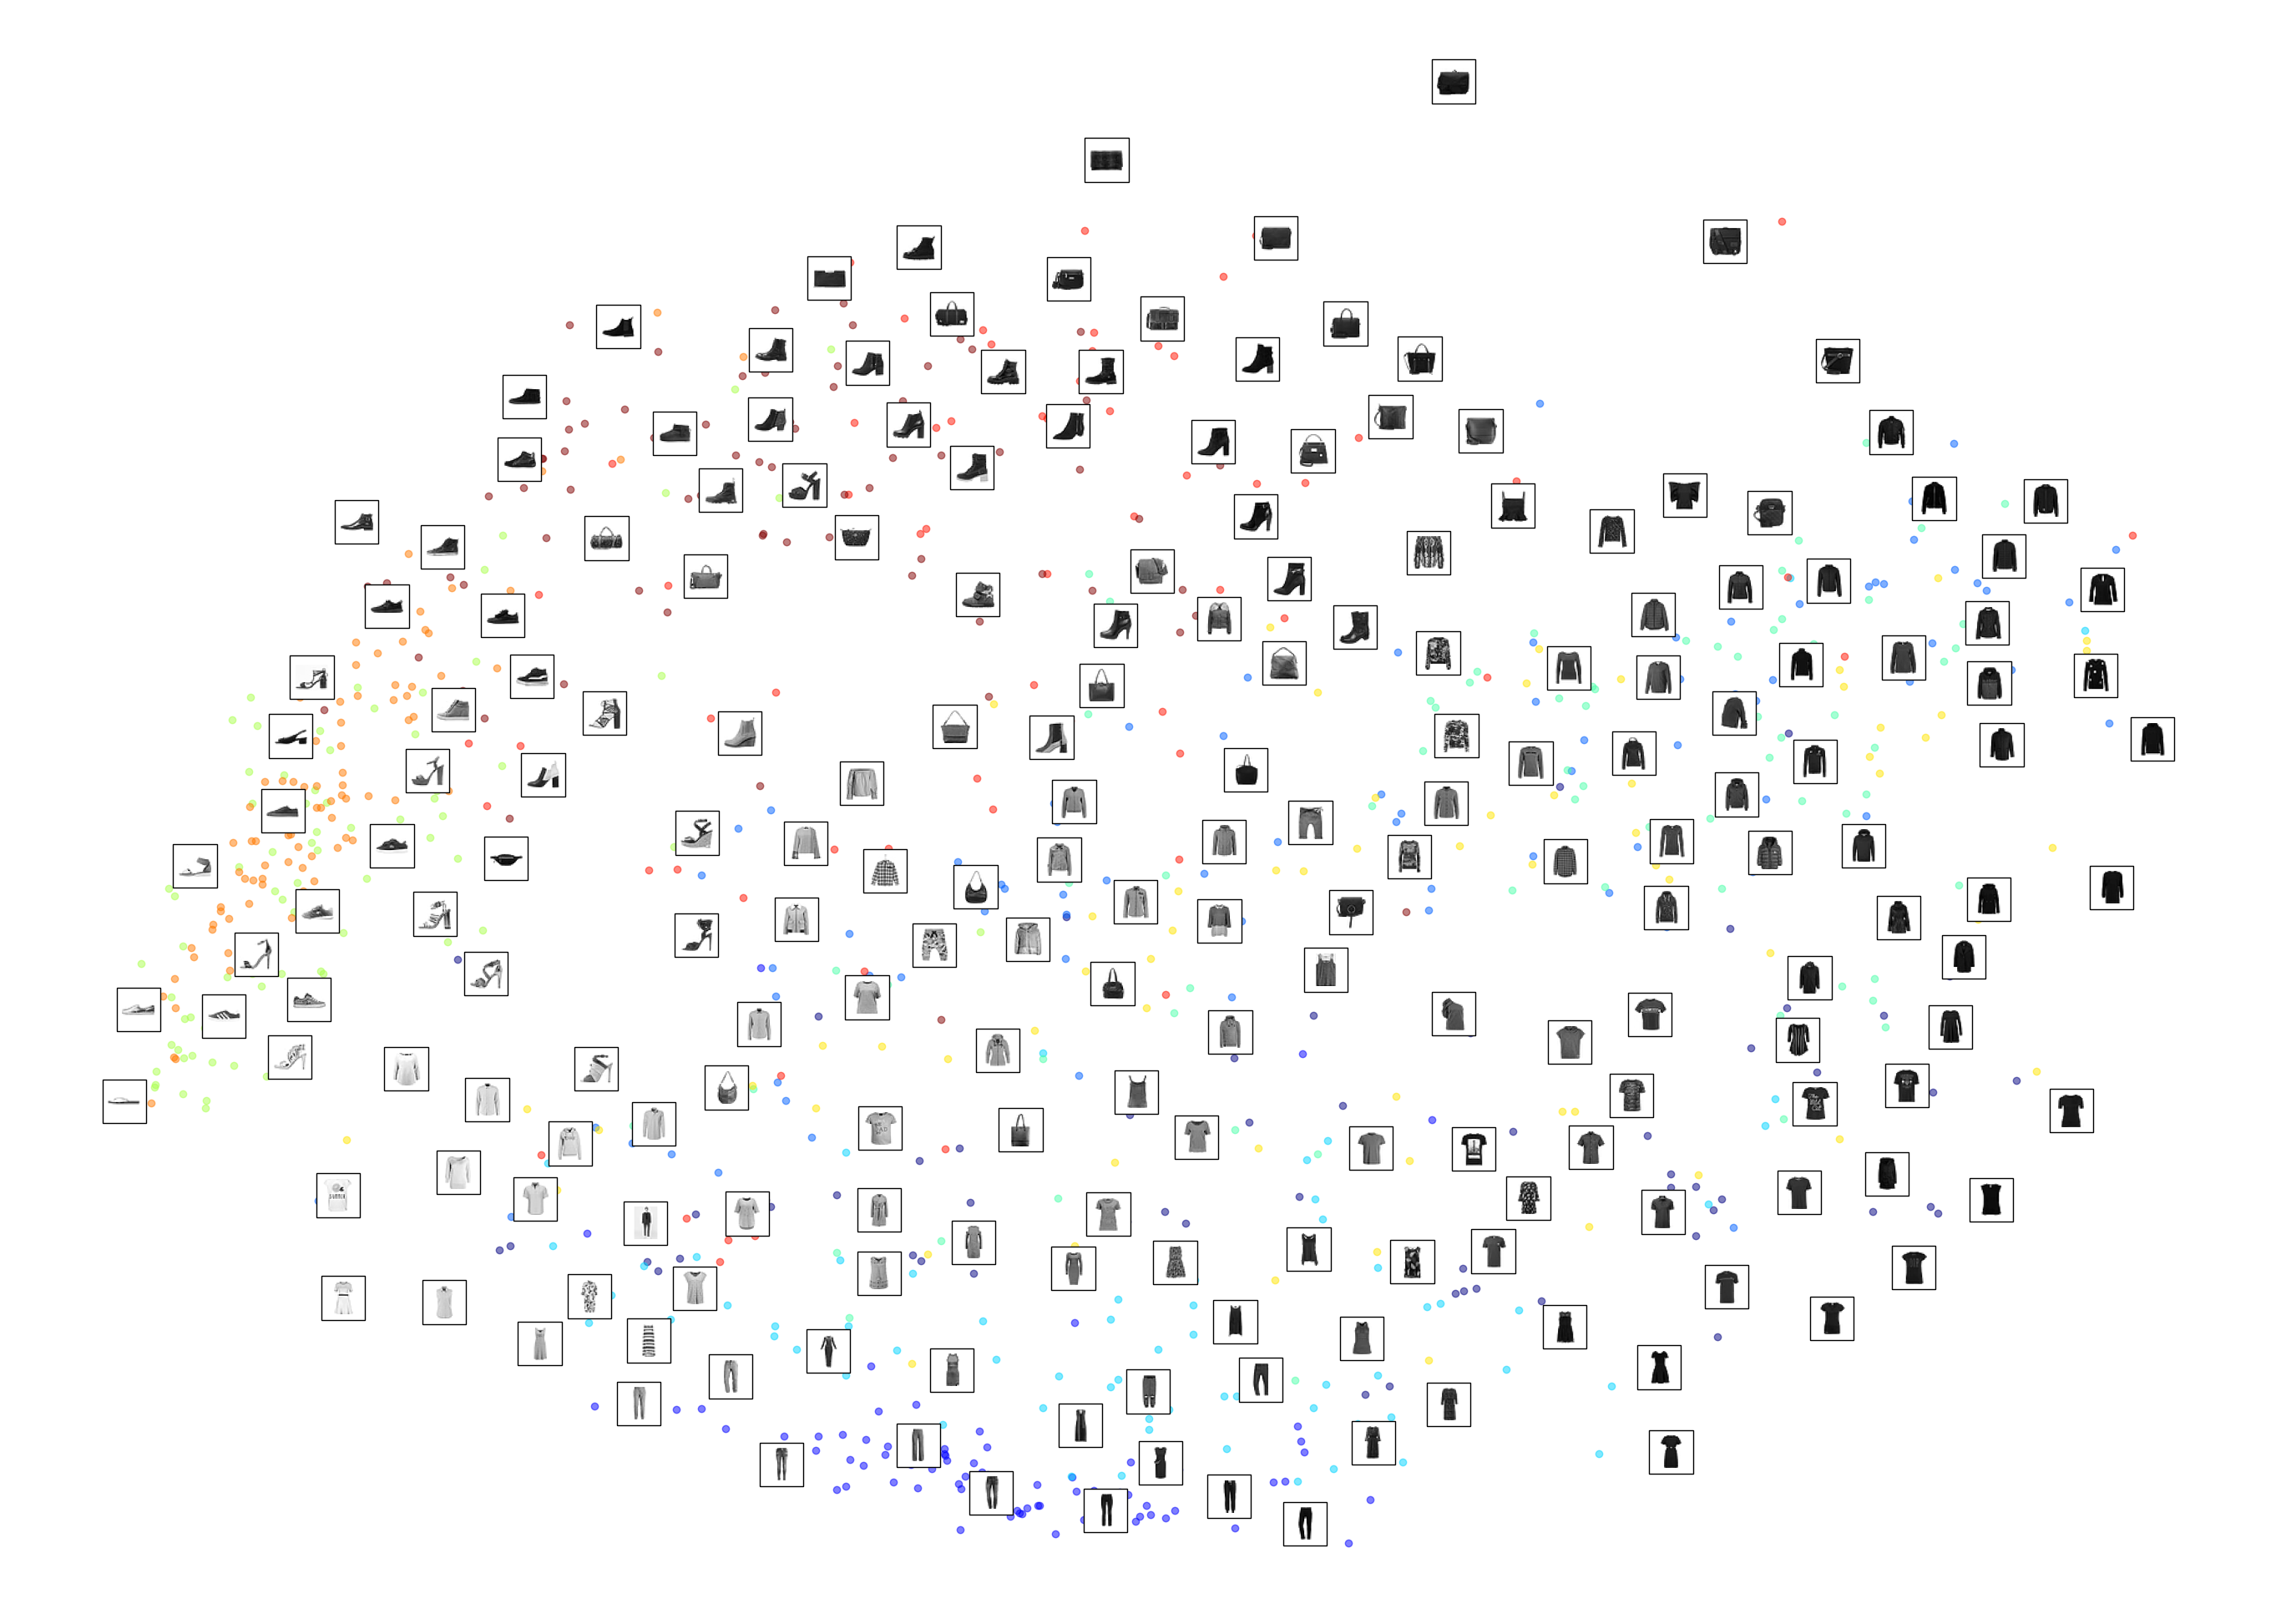

In [56]:
plot_digits(X_pca_reduced[:1000], y[:1000], images=X.values[:1000], figsize=(35, 25))

### 2. TSNE

In [57]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="random", learning_rate="auto", random_state=22)

In [58]:
X_tsne_reduced = tsne.fit_transform(X)

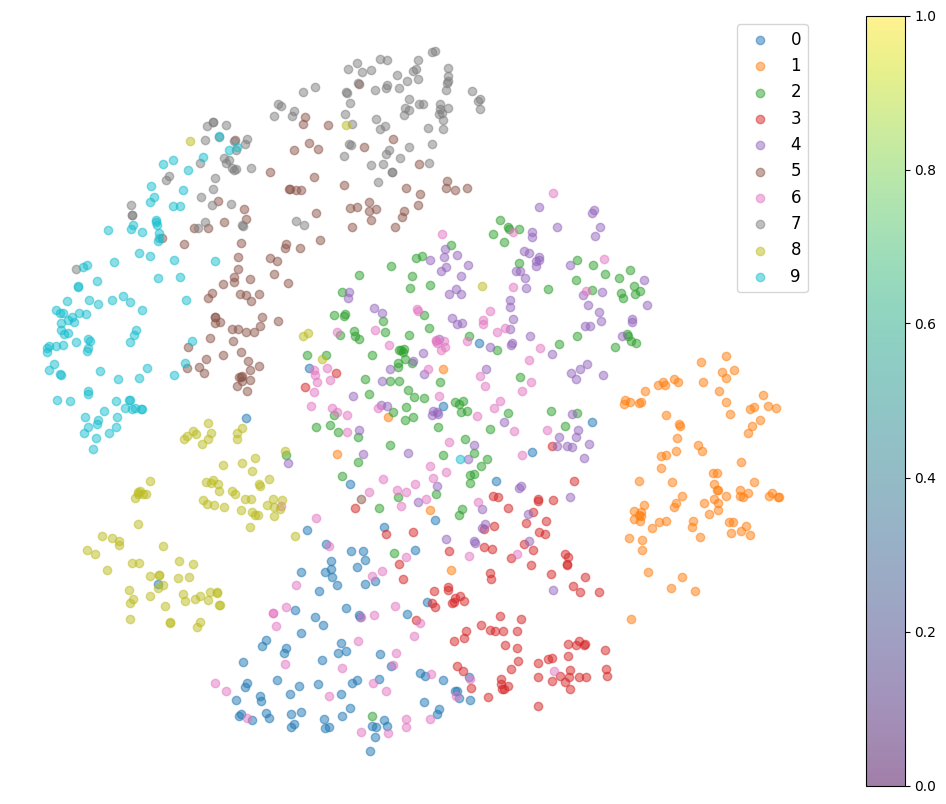

In [59]:
plot_principal_components(X_tsne_reduced[:1000], y[:1000])

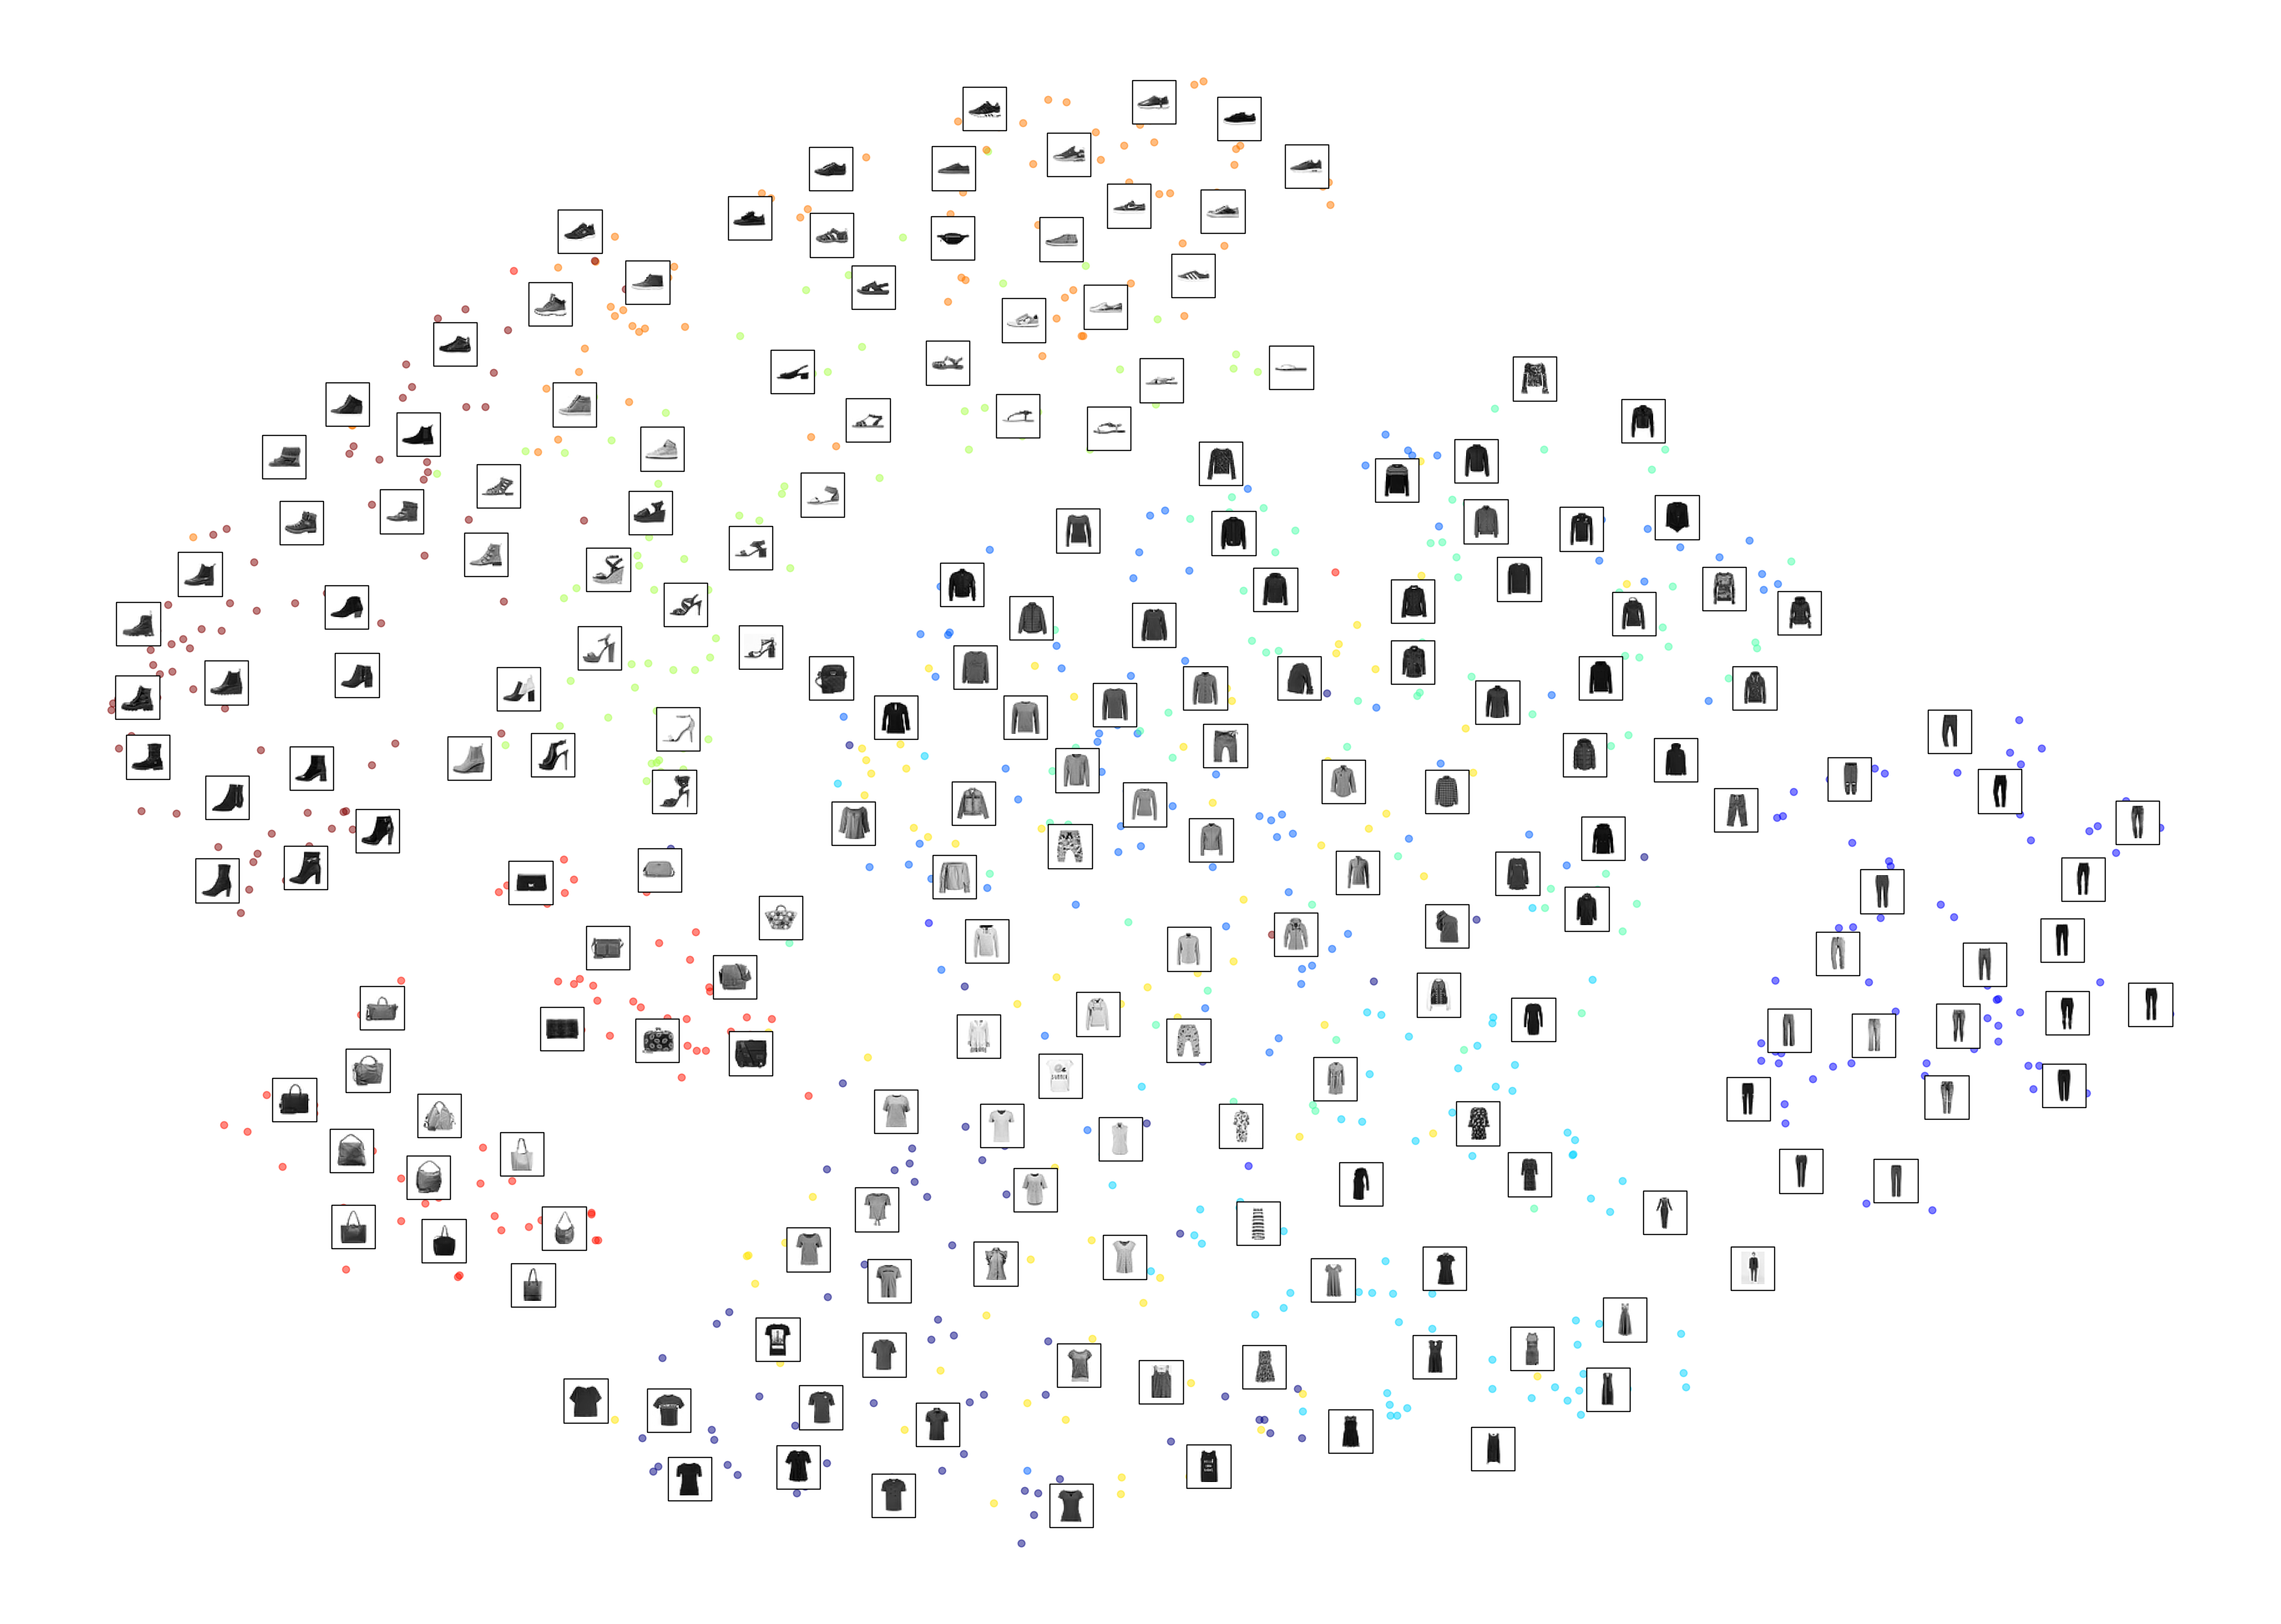

In [60]:
plot_digits(X_tsne_reduced[:1000], y[:1000], images=X.values[:1000], figsize=(35, 25))

### 3. LLE

In [61]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=22)

In [62]:
X_lle_reduced = lle.fit_transform(X)

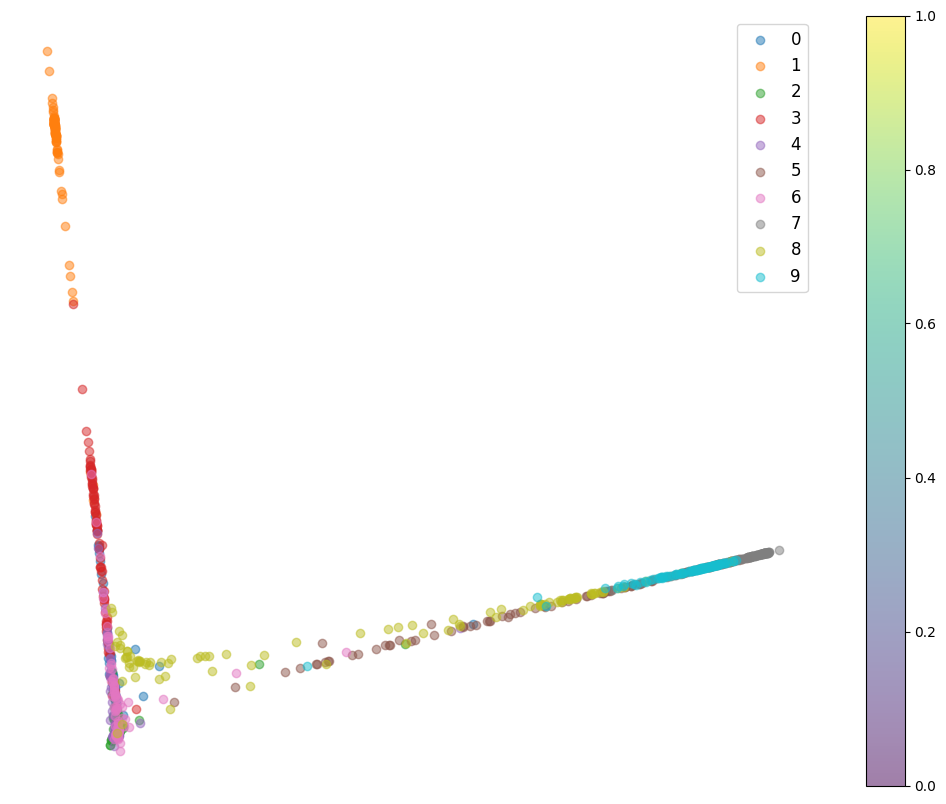

In [63]:
plot_principal_components(X_lle_reduced[:1000], y[:1000])

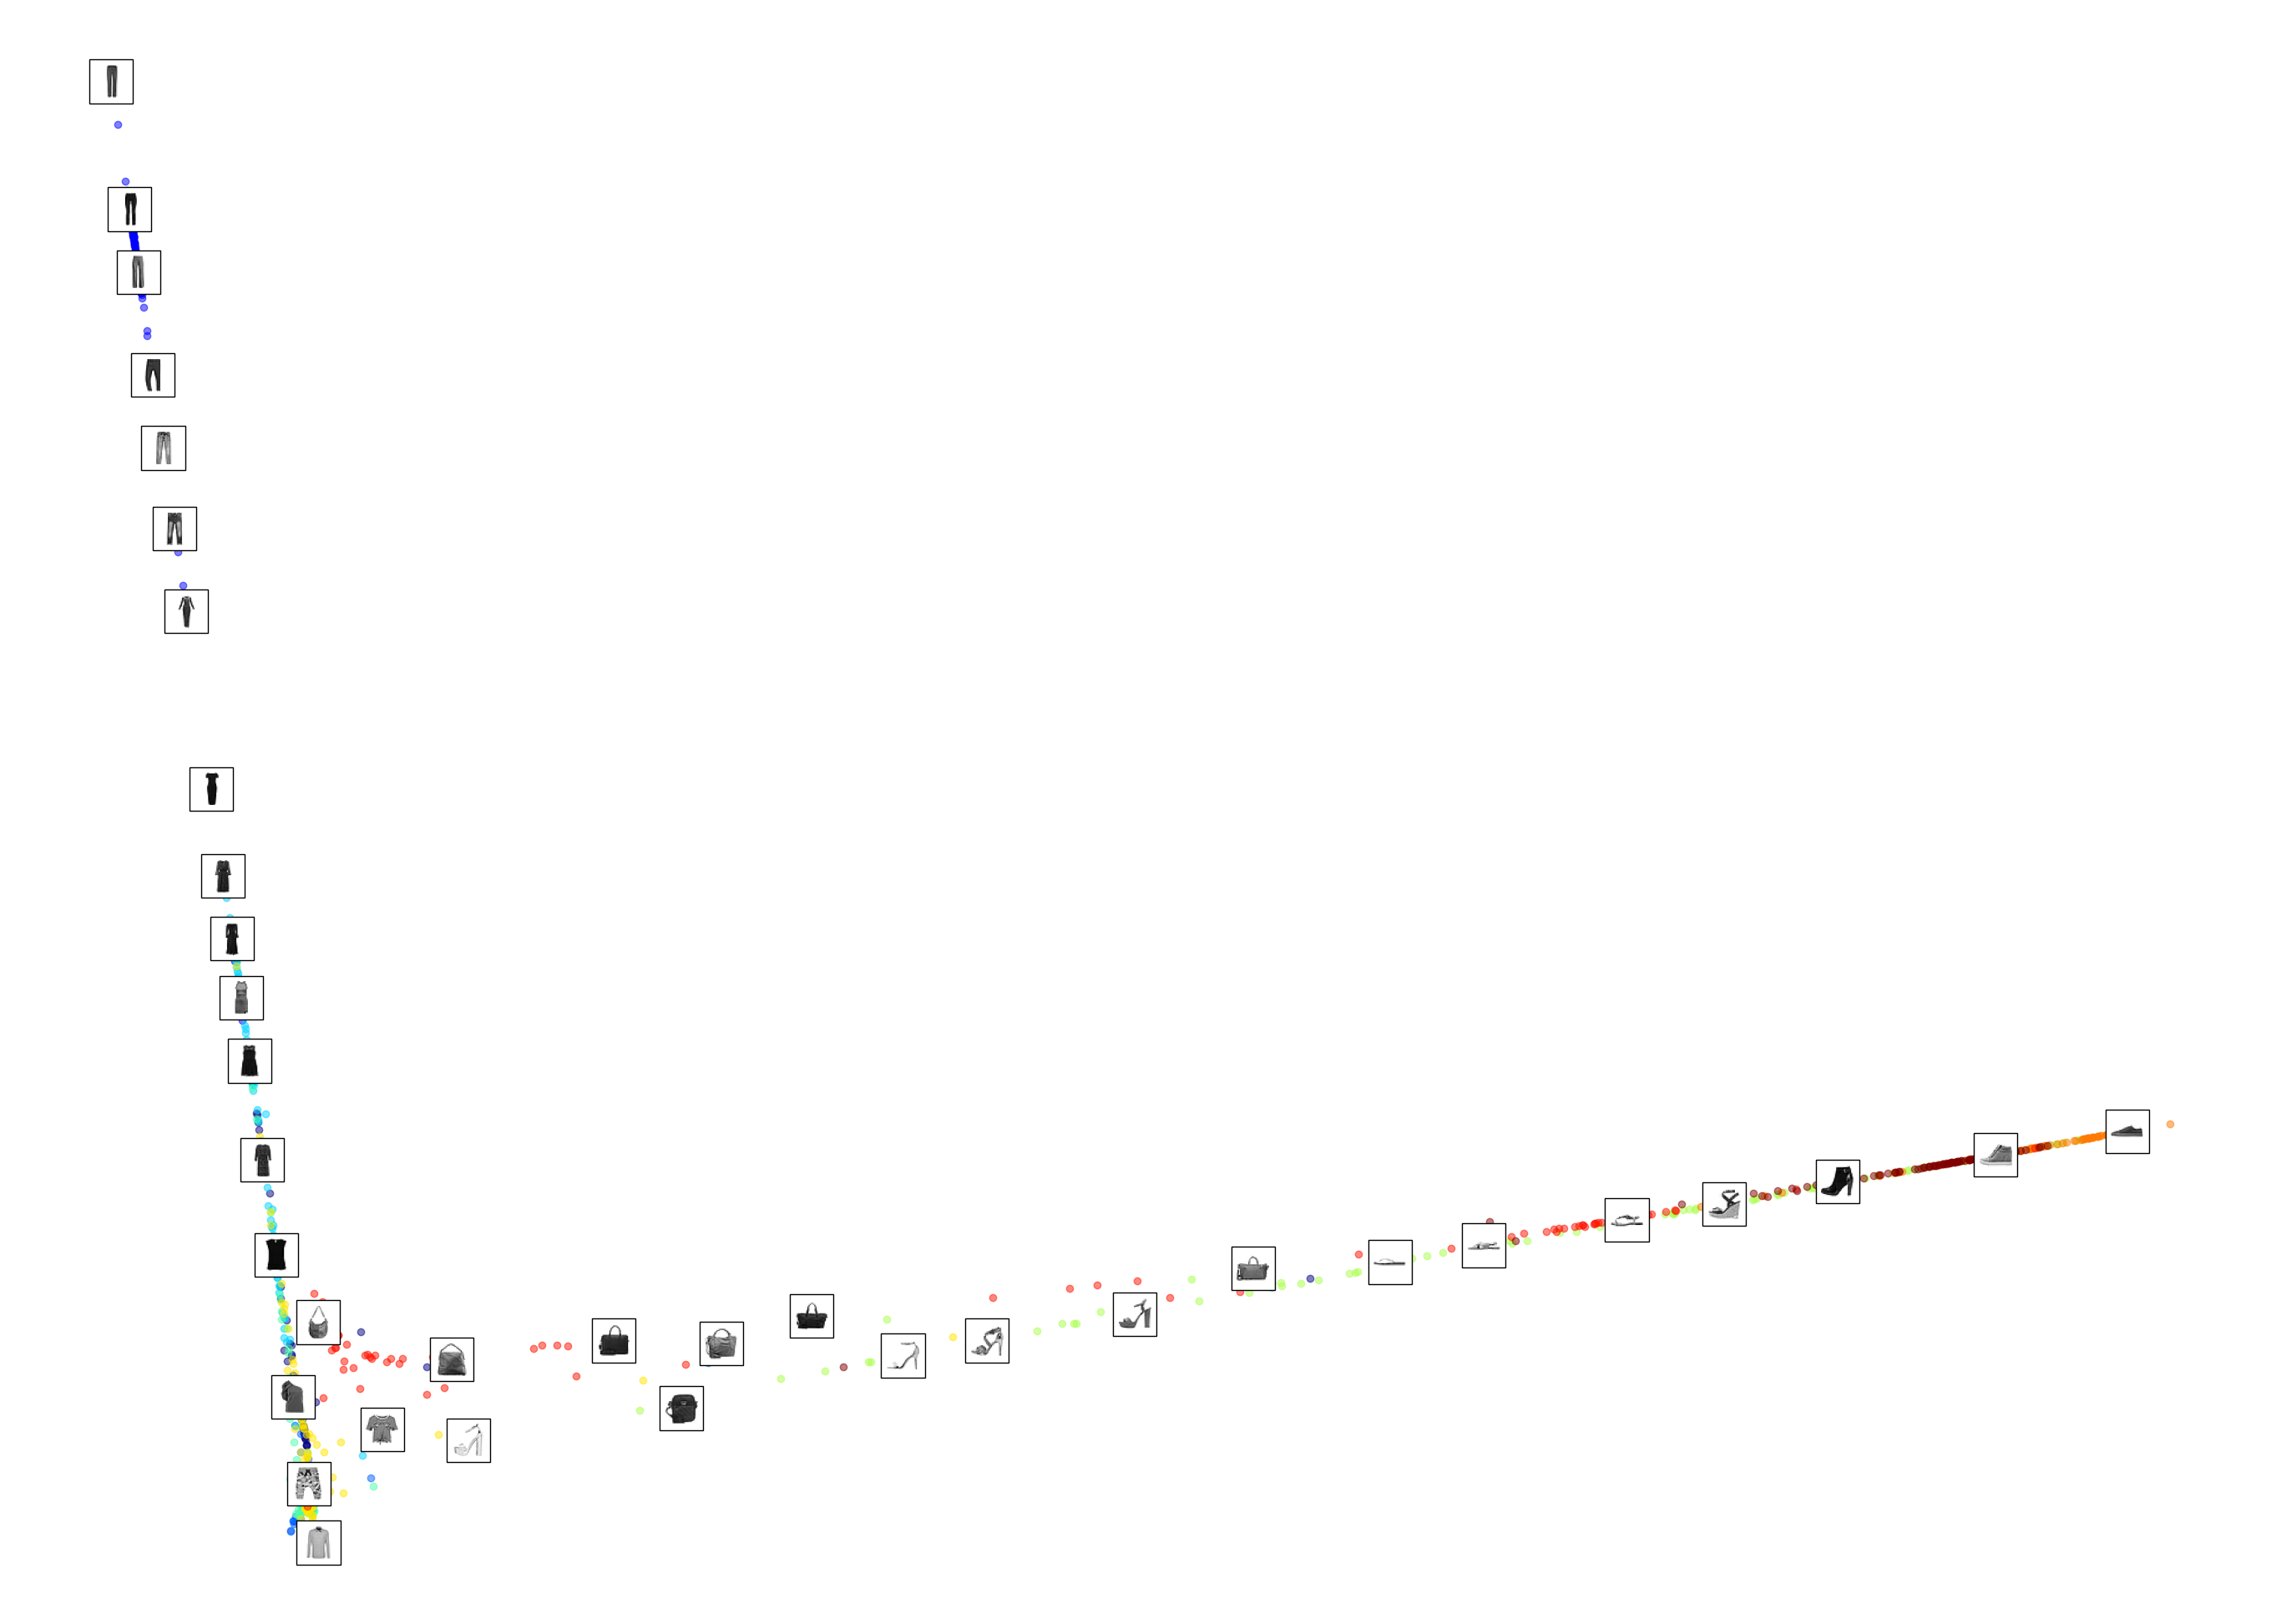

In [64]:
plot_digits(X_lle_reduced[:1000], y[:1000], images=X.values[:1000], figsize=(35, 25))

### 4. MDS

In [65]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=22)

In [66]:
random_sample = training_data.sample(n = 5000, random_state = 22)

In [67]:
X = random_sample
y = training_labels[random_sample.index]

In [68]:
X_mds_reduced = mds.fit_transform(X)

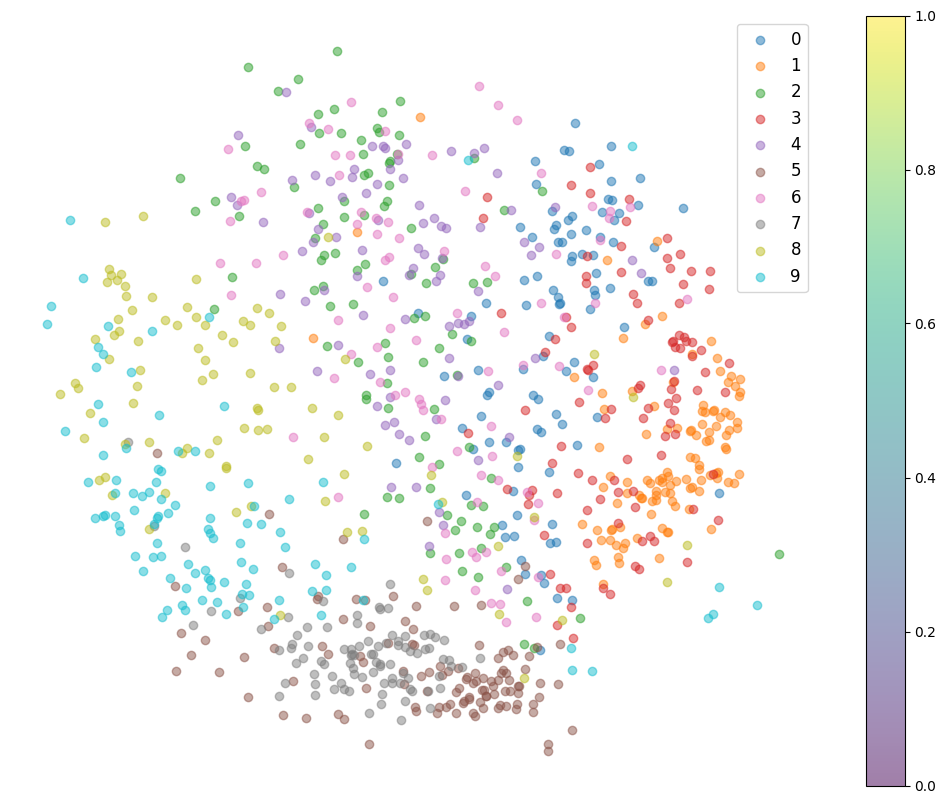

In [69]:
plot_principal_components(X_mds_reduced[:1000], y[:1000])

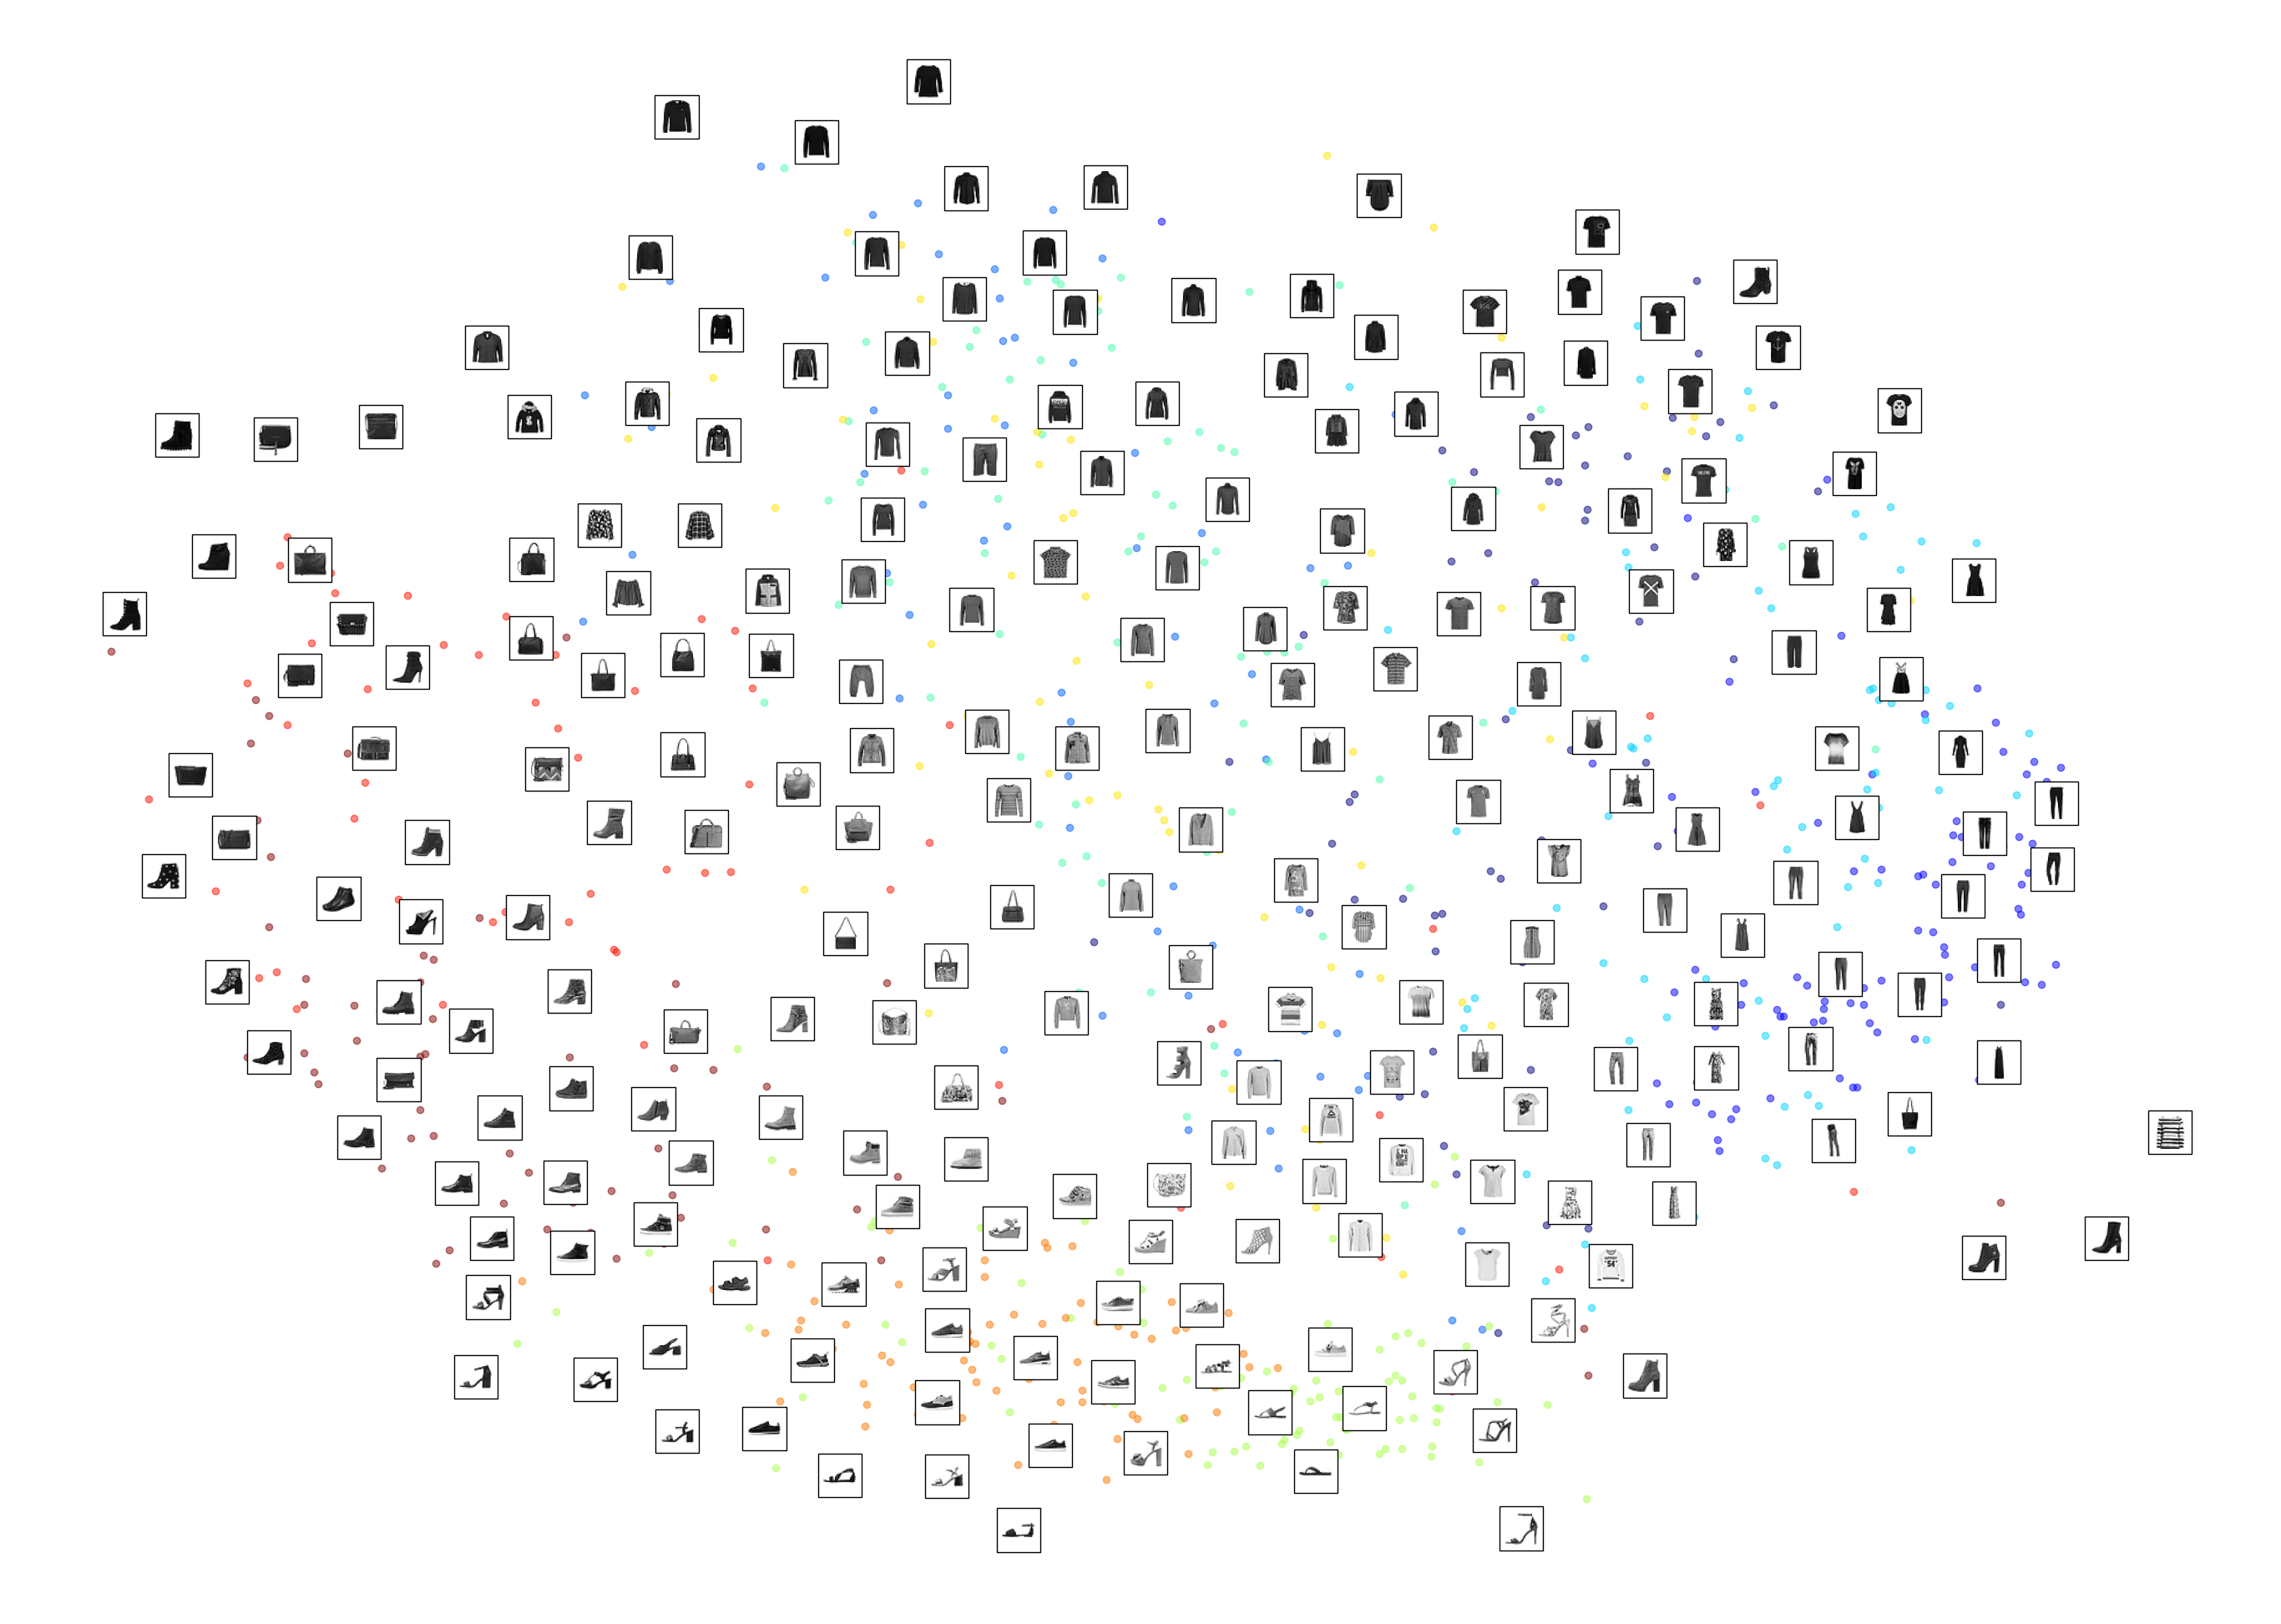

In [70]:
plot_digits(X_mds_reduced[:1000], y[:1000], images=X.values[:1000], figsize=(35, 25))

#### Answer: 
PCA, t-SNE, LLE and MDS are different dimentionality reduction techniques. We have visualized output of each method. 
Every visualization tries to show different clustering patterns between the data. For this example, we would generally prefer the visualization given by TSNE. The data seems visually separable, and is arranged in the form of clusters. If we look closely enough, TSNE managed to cluster all the shoes and its types, bags and apparel.

# ===============================================

### Question:
#### Take 10000 samples of the training portion of fashion MNIST dataset and cluster the images using K-Means. To speed up the algorithm, use PCA to reduce the dimensionality of the dataset. Ensure that you have a good number of clusters using one of the techniques we discussed in class. [4 points] Visualize the clusters (you can show only a subset of images): do you see similar clothing items in each cluster?

In [71]:
random_sample = training_data.sample(n = 10000, random_state = 22)

In [72]:
# Extracting 10000 samples of the trainig data
# Split the dataset into training and validation data sets
X_train = random_sample
y_train = training_labels[random_sample.index]


In [73]:
pca = PCA(0.95)
X_train_pca = pca.fit_transform(X_train)

First of all, we will run K-Means algorithm for different size of clusters. We can use silhouette score and inertia as one of the metrics to determine the optimum cluster size.

As suggested in problem statement, we will directly use the reduced data given by PCA insted of using the full dimention data.

In [74]:
from sklearn.cluster import KMeans

cluster_size_range = [5,10,15,20, 25,30,35,40]
kmeans_per_k = []
for k in cluster_size_range:
    print(f"Fitting data for Cluster Size={k}")
    kmeans_obj = KMeans(n_clusters=k, random_state=42, init="random", n_init=50)
    kmeans_obj.fit(X_train_pca)
    kmeans_per_k.append(kmeans_obj)

Fitting data for Cluster Size=5
Fitting data for Cluster Size=10
Fitting data for Cluster Size=15
Fitting data for Cluster Size=20
Fitting data for Cluster Size=25
Fitting data for Cluster Size=30
Fitting data for Cluster Size=35
Fitting data for Cluster Size=40


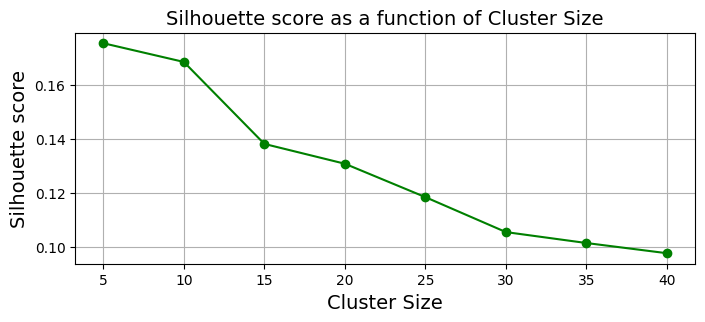

In [75]:
# plotting the silhouette score
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X_train_pca, model.labels_) for model in kmeans_per_k]

plt.figure(figsize=(8, 3))
plt.plot(cluster_size_range, silhouette_scores, "go-")
plt.title("Silhouette score as a function of Cluster Size")
plt.xlabel("Cluster Size")
plt.ylabel("Silhouette score")
plt.grid()
plt.show()

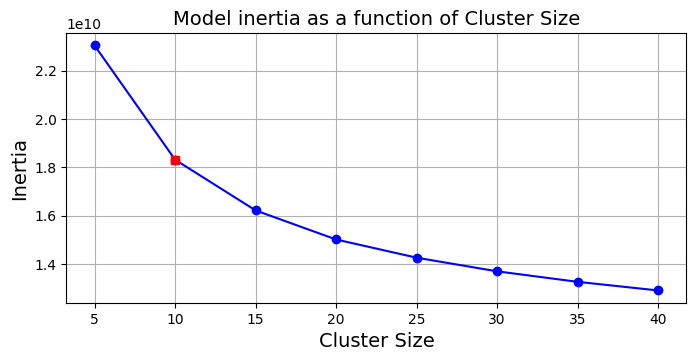

In [76]:
# plotting the intertia
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(cluster_size_range, inertias, "bo-")
plt.plot(10, inertias[1], "rs")
plt.title("Model inertia as a function of Cluster Size")
plt.xlabel("Cluster Size")
plt.ylabel("Inertia")
plt.grid()
plt.show()

####  By looking at the model inertia, the elbow is clearly visible at the cluster size 10

In [77]:
best_model = kmeans_per_k[2]

In [78]:
def plot_items(items, labels, n_cols=5):
    n_rows = (len(items) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (item, label) in enumerate(zip(items, labels)):
        item = item.reshape(28,28)
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(item, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

For convinience we have plotted first 20 images per cluster.

Cluster 0


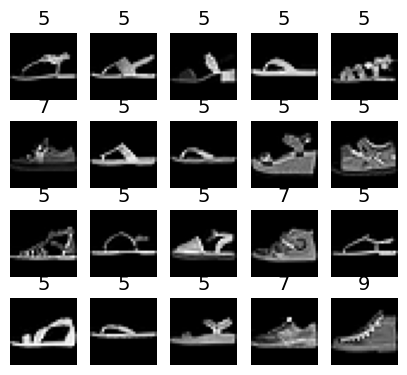

Cluster 1


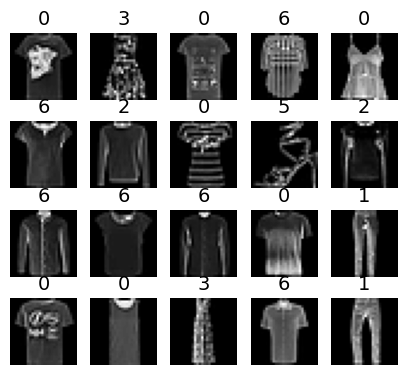

Cluster 2


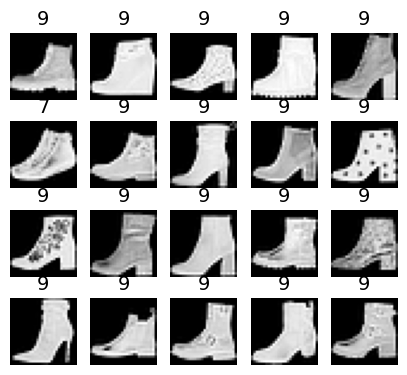

Cluster 3


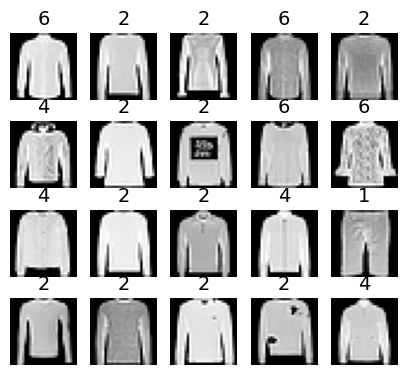

Cluster 4


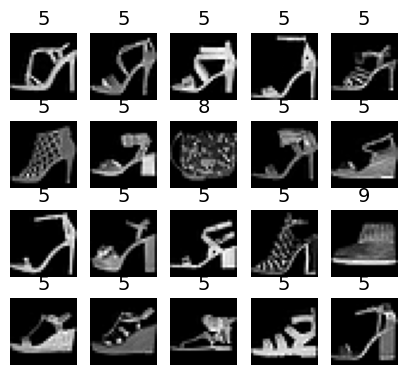

Cluster 5


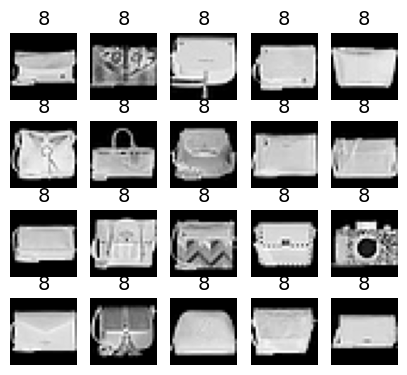

Cluster 6


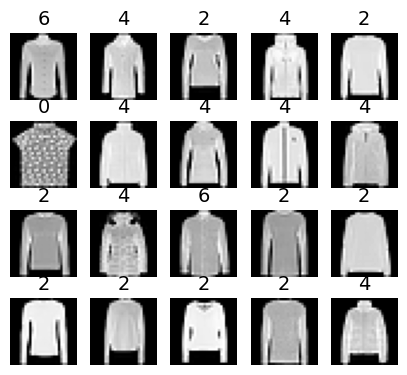

Cluster 7


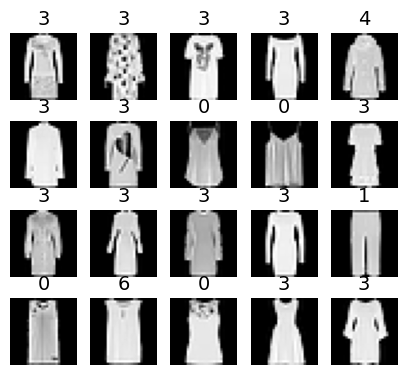

Cluster 8


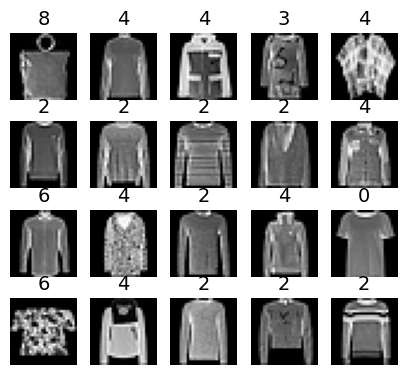

Cluster 9


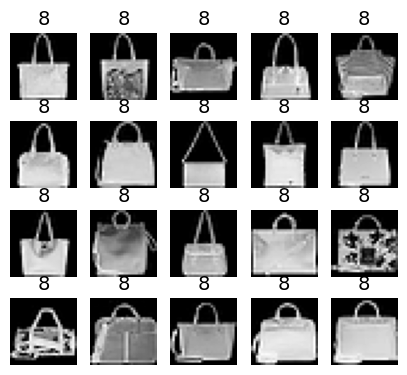

Cluster 10


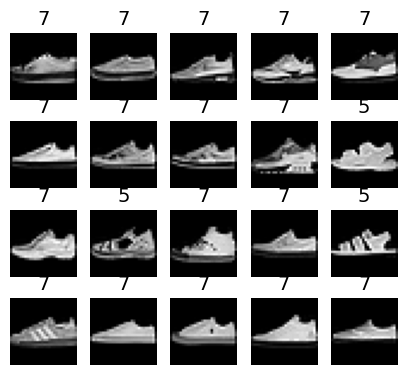

Cluster 11


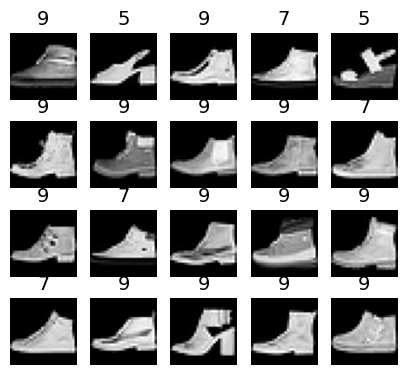

Cluster 12


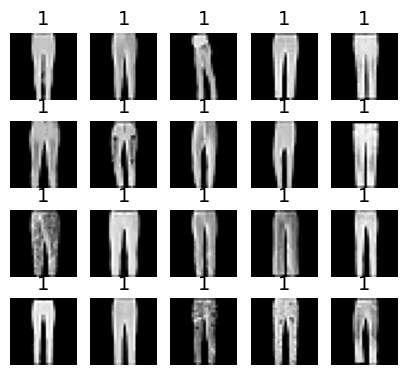

Cluster 13


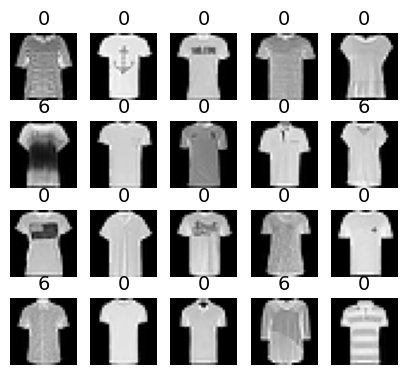

Cluster 14


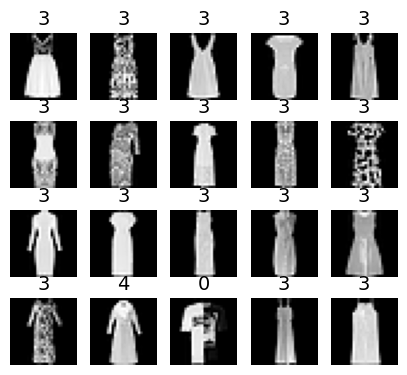

In [79]:
for cluster_id in np.unique(best_model.labels_):
    print("Cluster", cluster_id)
    in_cluster = best_model.labels_==cluster_id
    items = X_train[in_cluster]
    labels = y_train[in_cluster]
    plot_items(items.values[:20], labels[:20])

#### Answer:

There are certain clusters like cluster 0, 2, 4, 5, 9, 10 which contains most of the similar clothing types. Also, if we take the generality into consideration, the K-means clustering has managed to cluster the items with similar clothing type together. However, the heels, sandles and shooes are footware and the algorithm has managed to cluster those together. But there are some clusters(cluster 1, cluster 3, cluster 6, cluster 7), which has incorrectly classified the data.

# ====================================================

### Question: 

#### Take 10000 samples of the training portion of fashion MNIST dataset and cluster the images using a Gaussian mixture model. To speed up the algorithm, use PCA to reduce the dimensionality of the dataset. Ensure that you have a good number of clusters using one of the techniques we discussed in the class.

In [80]:
from sklearn.mixture import GaussianMixture

In [81]:
cluster_size_range = [5,10,15,20, 25,30,35,40]
gms_per_k = []
for k in cluster_size_range:
    print(f"Fitting data for Cluster Size={k}")
    gmm_model = GaussianMixture(n_components=k, n_init=10, random_state=42)
    gmm_model.fit(X_train_pca)
    gms_per_k.append(gmm_model)

Fitting data for Cluster Size=5
Fitting data for Cluster Size=10
Fitting data for Cluster Size=15
Fitting data for Cluster Size=20
Fitting data for Cluster Size=25
Fitting data for Cluster Size=30
Fitting data for Cluster Size=35
Fitting data for Cluster Size=40


In [82]:
BICS = [model.bic(X_train_pca) for model in gms_per_k]
AICS = [model.aic(X_train_pca) for model in gms_per_k]

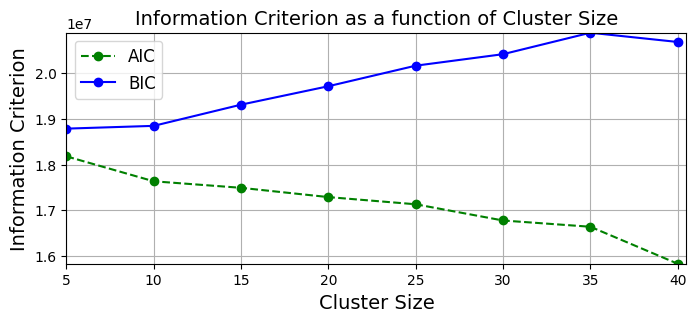

In [83]:
plt.figure(figsize=(8, 3))
plt.plot(cluster_size_range, AICS, "go--", label="AIC")
plt.plot(cluster_size_range, BICS, "bo-", label="BIC")
plt.title("Information Criterion as a function of Cluster Size")
plt.xlabel("Cluster Size")
plt.ylabel("Information Criterion")
plt.axis([min(cluster_size_range), max(cluster_size_range)+0.5, min(AICS) - 50, max(BICS) + 50])

plt.legend()
plt.grid()
plt.show()

If we look at the above figure, for K = 10, both BIC and AIC scores are minimum. After K = 10, BIC score increases whereas the AIC score decreases. If we have to find the optimum K, then it will be 10. Thus, we will select the number of clusters as 10.

In [84]:
best_gmm_model = gms_per_k[1]

In [85]:
best_gmm_model.n_components

10

For convinience we have plotted first 20 images per cluster.

Cluster 0


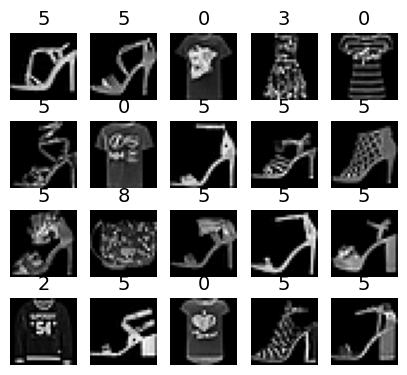

Cluster 1


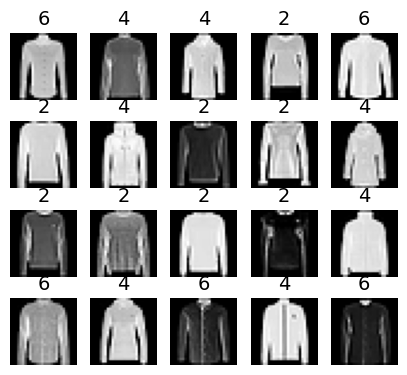

Cluster 2


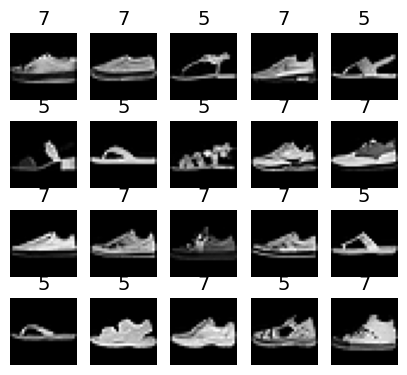

Cluster 3


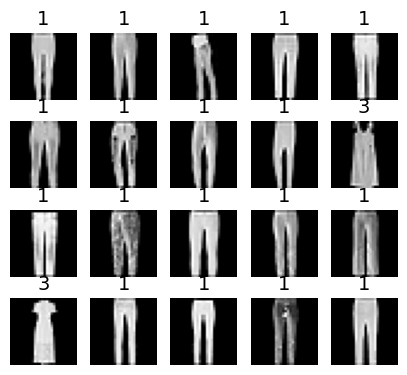

Cluster 4


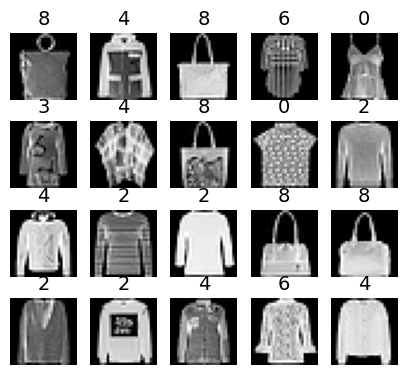

Cluster 5


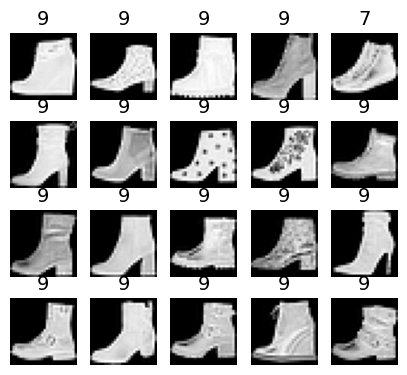

Cluster 6


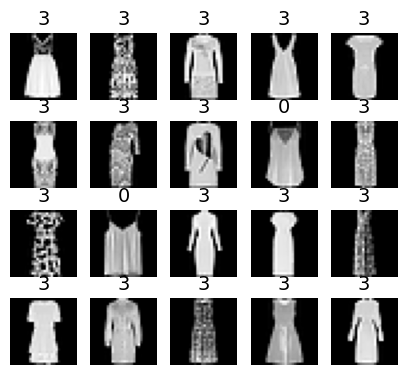

Cluster 7


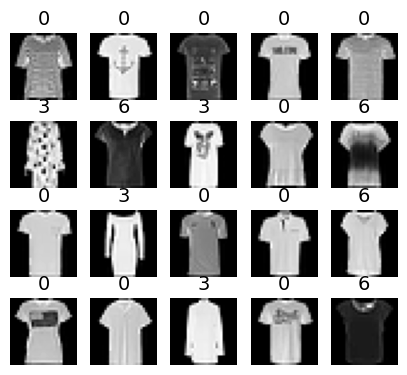

Cluster 8


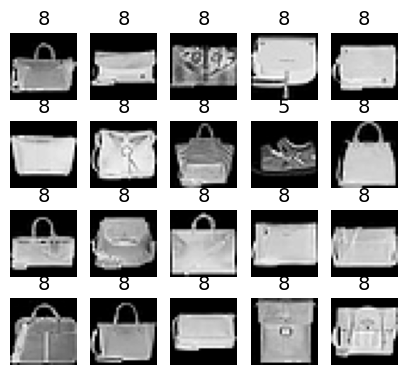

Cluster 9


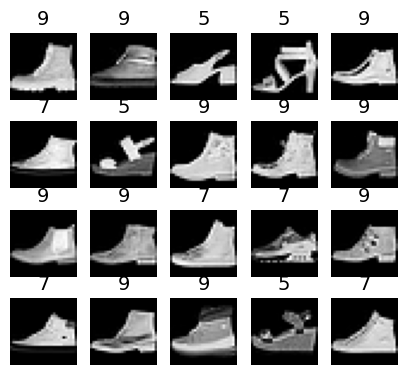

In [86]:
for cluster_id in range(best_gmm_model.n_components):
    print("Cluster", cluster_id)
    in_cluster = best_gmm_model.predict(X_train_pca) == cluster_id
    items = X_train[in_cluster]
    labels = y_train[in_cluster]
    plot_items(items.values[:20], labels[:20])

#### Question: Do you see similar clothing items in each cluster?

There are certain clusters like cluster 3, 5, 7, 8, 9 which contains most of the similar clothing types. Also, if we take the generality into consideration, the K-means clustering has managed to cluster the items with similar clothing type together. However, the heels, sandles and shooes are footware and the algorithm has managed to cluster those together. But there are some clusters(cluster 0, cluster 1, cluster 4), which has incorrectly classified the data.

### Question: 

Use the model to generate 20 new clothing items (using the sample() method), and visualize them (since you used PCA, you will need to use its inverse_transform() method).

In [87]:
gmm_model = GaussianMixture(n_components=best_gmm_model.n_components, n_init=10, random_state=22)

In [88]:
y_pred = gmm_model.fit_predict(X_train_pca)

In [89]:
n_items = 20
gen_items_reduced, y_gen_items = gmm_model.sample(n_samples=n_items)
gen_items = pca.inverse_transform(gen_items_reduced)

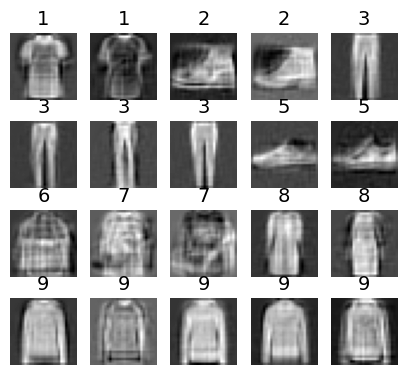

In [90]:
plot_items(gen_items, y_gen_items)

# ==================================================

### Question : 

Build a fully connected (dense) feedforward neural network with two hidden layers using Keras (within Tensorflow) and train it on 50k Fashion MNIST training images. First hidden layer should contain 200 neurons and second hidden layer should contain 50 neurons. The hidden layers should have ReLU activation function. Train the network for 100 epochs. Plot training and validation loss and accuracy as a function of training epochs. Try three different learning rates of your choice (make the plots for each learning rate). [8 points] 

In [91]:
# Split the dataset into training and validation data sets
split = StratifiedShuffleSplit(n_splits=1, test_size=1/6, random_state=22)
train_index, val_index = next(split.split(data, data_labels))

X_train = data.loc[train_index]
y_train = data_labels.loc[train_index]

X_valid = data.loc[val_index]
y_valid = data_labels.loc[val_index]

X_test = test_data
y_test = test_labels

In [92]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(50000, 784) (50000,)
(10000, 784) (10000,)
(10000, 784) (10000,)


In [93]:
from sklearn.decomposition import PCA

pca = PCA(0.95)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

In [94]:
pca.n_components_

187

In [95]:
def train_neural_net(model_name, X_train, y_train, X_valid, y_valid, learning_rate, activation_functions):
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)
    if Path(model_name).is_dir():
        model = tf.keras.models.load_model(model_name)
        history=np.load(model_name+'\\trainHistory.npy',allow_pickle='TRUE').item()
    else:
        norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
        model = tf.keras.Sequential([
        norm_layer,
        tf.keras.layers.Dense(200, activation=activation_functions["hidden_layer1"]),
        tf.keras.layers.Dense(50, activation=activation_functions["hidden_layer2"]),
        tf.keras.layers.Dense(10, activation=activation_functions["ouput_layer"])
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(loss=tf.keras.metrics.sparse_categorical_crossentropy, optimizer=optimizer, metrics=[tf.keras.metrics.sparse_categorical_accuracy ])
        norm_layer.adapt(X_train)
        history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid))
        model.save(model_name, save_format="tf")    
        np.save(model_name+'\\trainHistory.npy',history)
    return model, history

In [96]:
def plot_metrics(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

In [97]:
def print_test_metrics(model, X_test, y_test, learning_rate):
    loss_test, accuracy_test = model.evaluate(X_test, y_test)
    print("\nFor learning Rate : ", learning_rate)
    print("\t Reported Loss on Test set : ", round(loss_test, 4))
    print("\t Reported accuracy on Test set : ", round(accuracy_test, 4))

# Using Learning rate as 0.001 i.e. 1e-3

In [98]:
activation_functions = {'hidden_layer1': 'relu', 
                        'hidden_layer2': 'relu',
                        'ouput_layer': 'softmax'}

In [99]:
%%capture
learning_rate = 1e-3
model, history = train_neural_net("neural_net_LR1e-03", X_train, y_train, X_valid, y_valid, learning_rate, activation_functions)

INFO:tensorflow:Assets written to: neural_net_LR1e-03\assets


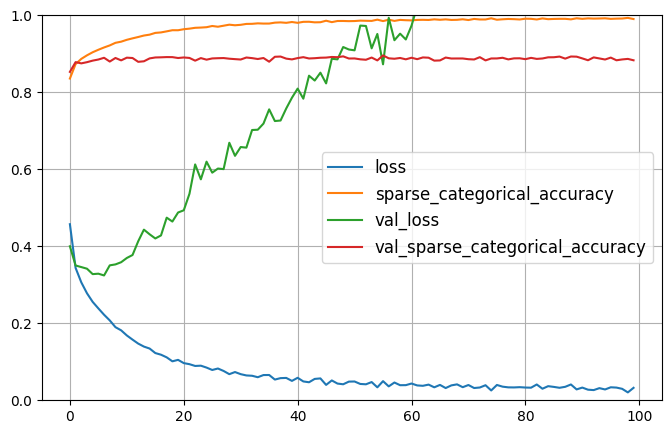

In [100]:
plot_metrics(history)

In [101]:
print_test_metrics(model, X_test, y_test, learning_rate)

313/313 [==============================] - 0s 987us/step - loss: 1.3602 - sparse_categorical_accuracy: 0.8911

For learning Rate :  0.001
	 Reported Loss on Test set :  1.3602
	 Reported accuracy on Test set :  0.8911


# Using Learning rate as 0.00001 i.e. 1e-5

In [102]:
%%capture
learning_rate = 1e-5
model, history = train_neural_net("neural_net_LR1e-5", X_train, y_train, X_valid, y_valid, learning_rate, activation_functions)

INFO:tensorflow:Assets written to: neural_net_LR1e-5\assets


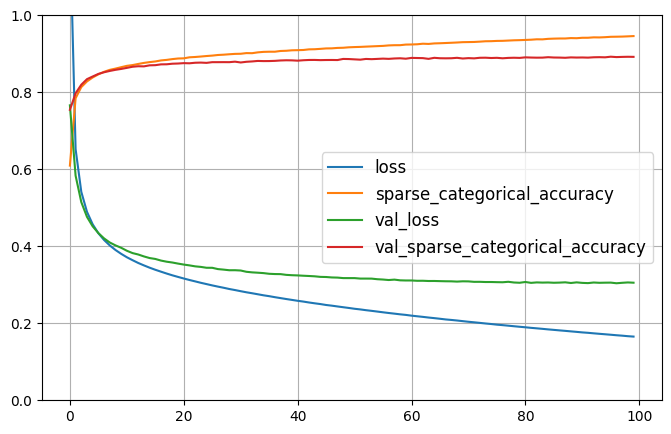

In [103]:
plot_metrics(history)

In [104]:
print_test_metrics(model, X_test, y_test, learning_rate)

313/313 [==============================] - 0s 945us/step - loss: 0.2946 - sparse_categorical_accuracy: 0.8939

For learning Rate :  1e-05
	 Reported Loss on Test set :  0.2946
	 Reported accuracy on Test set :  0.8939


# Using Learning rate as 0.000000001 i.e. 1e-9

In [105]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [106]:
%%capture
learning_rate = 1e-9
model, history = train_neural_net("neural_net_LR1e-9", X_train, y_train, X_valid, y_valid, learning_rate, activation_functions)

INFO:tensorflow:Assets written to: neural_net_LR1e-9\assets


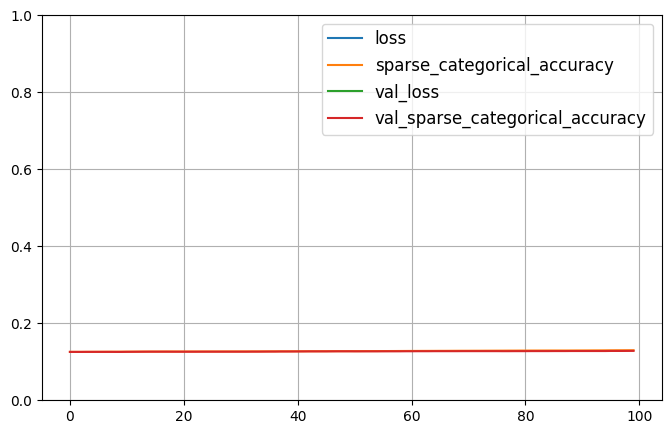

In [107]:
plot_metrics(history)

In [108]:
print_test_metrics(model, X_test, y_test, learning_rate)

313/313 [==============================] - 0s 961us/step - loss: 2.5646 - sparse_categorical_accuracy: 0.1307

For learning Rate :  1e-09
	 Reported Loss on Test set :  2.5646
	 Reported accuracy on Test set :  0.1307


### Question:

Run the network on the test portion of the dataset using best-performing learning rate and report loss and accuracy. [2 points] How many parameters does the network have? How many of those parameters are bias parameters?

##### The best performing learning rate is 0.00001 i.e. 1e-5 with reported loss = 30.38% and accuracy 89.29%

The criteria used for selecting the best performing model for this example is to select model with minimal loss and highest accuracy

The model is trained under below architecture

In [109]:
model = tf.keras.Sequential([
tf.keras.layers.Normalization(input_shape=X_train.shape[1:]),
tf.keras.layers.Dense(200, activation=activation_functions["hidden_layer1"]),
tf.keras.layers.Dense(50, activation=activation_functions["hidden_layer2"]),
tf.keras.layers.Dense(10, activation=activation_functions["ouput_layer"])
])

In [110]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 784)              1569      
 ion)                                                            
                                                                 
 dense_3 (Dense)             (None, 200)               157000    
                                                                 
 dense_4 (Dense)             (None, 50)                10050     
                                                                 
 dense_5 (Dense)             (None, 10)                510       
                                                                 
Total params: 169,129
Trainable params: 167,560
Non-trainable params: 1,569
_________________________________________________________________


### Answers:

1. The total parameters available are 169129, out of those the trainable parameters are 167560 and non trainable parameters are 1569.

2. There are in total 200 bias parameters for hidden layer 1, 50 bias parameters for hidden layer 2 and 10 bias parameters for output layer, which makes in total 260 bias parameters.

### Question: 

Repeat everything from the previous step but make the hidden layers have linear activation functions. [5 points] Discuss how this impacts accuracy and why. [2 points]


### Using Learning rate as 0.001 i.e. 1e-3

In [111]:
linear_activation_functions = {'hidden_layer1': 'linear', 
                        'hidden_layer2': 'linear',
                        'ouput_layer': 'softmax'}

In [112]:
# %%capture
learning_rate = 1e-3
model, history = train_neural_net("neural_net_LR1e-3_linear", X_train, y_train, X_valid, y_valid, learning_rate, linear_activation_functions)

Epoch 1/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.5767 - sparse_categorical_accuracy: 0.8095 - val_loss: 0.5126 - val_sparse_categorical_accuracy: 0.8236
Epoch 2/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.4843 - sparse_categorical_accuracy: 0.8339 - val_loss: 0.4838 - val_sparse_categorical_accuracy: 0.8285
Epoch 3/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.4617 - sparse_categorical_accuracy: 0.8394 - val_loss: 0.4679 - val_sparse_categorical_accuracy: 0.8369
Epoch 4/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.4452 - sparse_categorical_accuracy: 0.8450 - val_loss: 0.4713 - val_sparse_categorical_accuracy: 0.8365
Epoch 5/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.4369 - sparse_categorical_accuracy: 0.8471 - val_loss: 0.4696 - val_sparse_categorical_accuracy: 0.8389
Epoch 6/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.4302 -

1563/1563 [==============================] - 3s 2ms/step - loss: 0.3588 - sparse_categorical_accuracy: 0.8720 - val_loss: 0.5072 - val_sparse_categorical_accuracy: 0.8407
Epoch 90/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.3583 - sparse_categorical_accuracy: 0.8724 - val_loss: 0.4852 - val_sparse_categorical_accuracy: 0.8423
Epoch 91/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.3577 - sparse_categorical_accuracy: 0.8728 - val_loss: 0.4913 - val_sparse_categorical_accuracy: 0.8405
Epoch 92/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.3591 - sparse_categorical_accuracy: 0.8718 - val_loss: 0.4846 - val_sparse_categorical_accuracy: 0.8438
Epoch 93/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.3584 - sparse_categorical_accuracy: 0.8725 - val_loss: 0.4915 - val_sparse_categorical_accuracy: 0.8393
Epoch 94/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.3574 - sparse

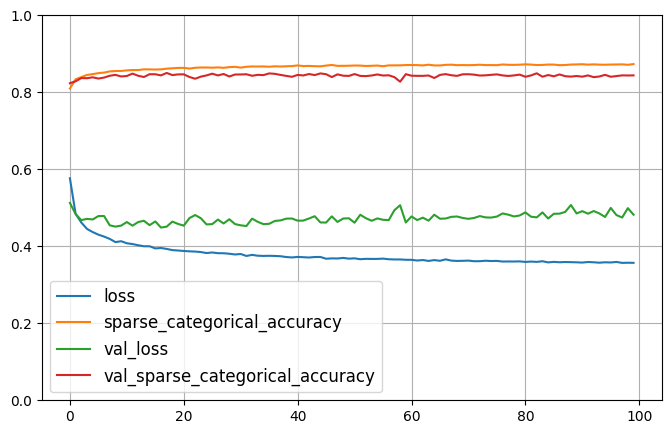

In [113]:
plot_metrics(history)

In [114]:
print_test_metrics(model, X_test, y_test, learning_rate)

313/313 [==============================] - 0s 935us/step - loss: 0.4827 - sparse_categorical_accuracy: 0.8439

For learning Rate :  0.001
	 Reported Loss on Test set :  0.4827
	 Reported accuracy on Test set :  0.8439


### Using Learning rate as 0.00001 i.e. 1e-5

In [115]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [116]:
%%capture
learning_rate = 1e-5
model, history = train_neural_net("neural_net_LR1e-5_linear", X_train, y_train, X_valid, y_valid, learning_rate, linear_activation_functions)

INFO:tensorflow:Assets written to: neural_net_LR1e-5_linear\assets


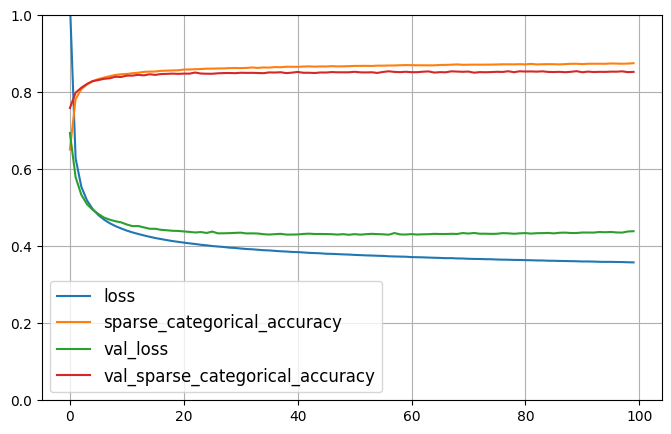

In [117]:
plot_metrics(history)

In [118]:
print_test_metrics(model, X_test, y_test, learning_rate)

313/313 [==============================] - 0s 1ms/step - loss: 0.4417 - sparse_categorical_accuracy: 0.8511

For learning Rate :  1e-05
	 Reported Loss on Test set :  0.4417
	 Reported accuracy on Test set :  0.8511


### Using Learning rate as 0.000000001 i.e. 1e-9

In [119]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [120]:
%%capture
learning_rate = 1e-9
model, history = train_neural_net("neural_net_LR1e-9_linear", X_train, y_train, X_valid, y_valid, learning_rate, linear_activation_functions)

INFO:tensorflow:Assets written to: neural_net_LR1e-9_linear\assets


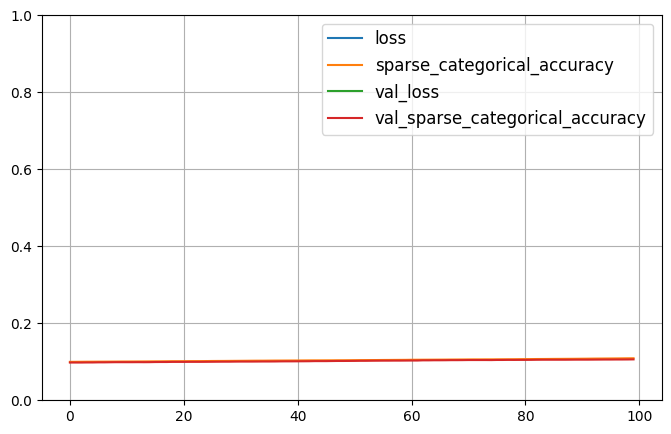

In [121]:
plot_metrics(history)

In [122]:
print_test_metrics(model, X_test, y_test, learning_rate)

313/313 [==============================] - 0s 1ms/step - loss: 3.5172 - sparse_categorical_accuracy: 0.1099

For learning Rate :  1e-09
	 Reported Loss on Test set :  3.5172
	 Reported accuracy on Test set :  0.1099


##### The best performing learning rate for NN with linear activation is 0.00001 i.e. 1e-5 with reported loss = 44.17% and accuracy 85.11%

### Question:
Discuss how using linear activation function impacts accuracy and why. [2 points]

Here, we have used linear activation function. This can be done using setting activation function as `None` or `Linear`.

The linear activation function is set for the 2 hidden layers of the neural network. We can observe following things:

For Learning rate as 0.001 i.e. 1e-3 :

ReLU activation :
    loss : 1.2827
    Accuracy : 0.8874
    
Linear Activation:
    loss : 0.4864
    Accuracy : 0.8436


For Learning rate as 0.00001 i.e. 1e-5 :

ReLU activation : 
    loss : 0.3038
    Accuracy : 0.8929
    
Linear Activation:
    loss :  0.4376
    Accuracy : 0.8512


For Learning rate as 0.000000001 i.e. 1e-9 :

ReLU activation :
    loss : 2.634
    Accuracy : 0.1281
    
Linear Activation:
    loss :  3.5876
    Accuracy : 0.1105


##### Observations : 

1. The linear model performs better for the 2 learning rates (1e-3 and 1e-5) than a model with ReLU activation. This might happen because of the neural network we have created is shallow.(contains only 2 hidden layers). If the network is deep enough, we might have been able to see some differences. 
2. Also, as our dataset is MNIST like, one of the possibility is that the model might be learned the linear combination of features.
3. One more possibility is that, the ReLU might have overfitted on the training data causing it to give huge loss on the test data.

# Acknowledgements:

We would like to thank Prof. Zoran Tiganj for his guidance on the plotting scatterplot using principle components for different dimentionality reduction methodologies. Also, we have worked according to his suggestion about following code on the github repository of Machine Learning Notebooks by A. Geron.

# References : 

[1] Geron, A. (2019). Hands-on machine learning with scikit-learn, keras, and TensorFlow: Concepts, tools, and techniques to build intelligent systems (2nd ed.). O’Reilly Media.

[2] Machine Learning Notebooks(8,9,10) on GitHub by A. Geron. https://github.com/ageron/handson-ml2 , https://github.com/ageron/handson-ml3

[2] API Reference. (n.d.). Scikit-learn. https://scikit-learn.org/stable/modules/classes.html

[3] API Reference. (n.d.). Pandas. https://pandas.pydata.org/docs/user_guide/index.html

[4] API Reference. (n.d.). NumPy. https://numpy.org/doc/stable/user/index.html#user

[5] How to save dictionaries : https://stackoverflow.com/questions/40219946/python-save-dictionaries-through-numpy-save
